In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import warnings
warnings.filterwarnings('ignore', '', UserWarning)

import torch
torch.manual_seed(1)
torch.cuda.manual_seed(1)

In [5]:
import os
os.chdir('..')

In [8]:
os.makedirs('data/dsprites', exist_ok=True)

In [10]:
dataset_params = {
    'dataset': 'dsprites',
    'batch_size': 32,
    'cuda': True,
    'root': 'data'
}

from src.utils import get_datasets
train_loader, test_loader, (width, height, channels) = get_datasets(
    **dataset_params)

Loading dsprites dataset...
Done!



In [12]:
%%time
from src.models.conv_vsc import ConvolutionalVariationalSparseCoding

model_params = {
    'dataset': 'dsprites',
    'width': width,
    'height': height,
    'channels': channels,
    'kernel_szs': '32,32,64,64',
    'hidden_sz': 256,
    'latent_sz': 100,
    'learning_rate': 3e-4,
    
    'alpha': 0.1,
    'beta': 1.25,
    'beta_delta': 0,
    'c': 100,
    'c_delta': 1e-3, 
    
    'device': 'cpu',
    'log_interval': 5000,
    'normalize': False,
    'flatten': False
}

convvsc = ConvolutionalVariationalSparseCoding(**model_params)

CPU times: user 1.51 s, sys: 927 ms, total: 2.44 s
Wall time: 3.94 s


In [87]:
convvsc.model.load_state_dict(torch.load(
    'data/checkpoints/convvsc_dsprites_12e_100z.pth', map_location='cpu'))

In [17]:
images, _ = iter(test_loader).next()

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import torchvision

def plot_image(img, ax, title):
    ax.imshow(np.transpose(img, (1,2,0)) , interpolation='nearest')
    ax.set_title(title, fontsize=20)
    
def to_numpy(image, vsc):
    return torchvision.utils.make_grid(
        image.view(1, vsc.channels, vsc.height, vsc.width)
    ).cpu().detach().numpy()
    
def plot_encoding(image, vsc, latent_sz, alpha, width=1/7):
    image = vsc.transform(image).to(vsc.device)
    decoded, mu, logvar, logspike = vsc.model.forward(image)
    z = vsc.model.reparameterize(mu, logvar, logspike)
    img = vsc.inverse_transform(vsc.model.decode(z))
    z = z.cpu().detach().numpy()[0]
    
    fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, figsize=(14,5))
    
    plot_image(to_numpy(image, vsc), ax0, 'Input Image')
    
    ax1.bar(np.arange(latent_sz), height=z, width=width, align='center')
    ax1.scatter(np.arange(latent_sz), z, color='blue')
    ax1.set_title(r"Latent Dimension %d - $\alpha$ = %.2f " % \
                  (latent_sz, alpha), fontsize=20)
    
    plot_image(to_numpy(img, vsc), ax2, 'Decoded Image')
    plt.subplots_adjust(hspace=0.5)

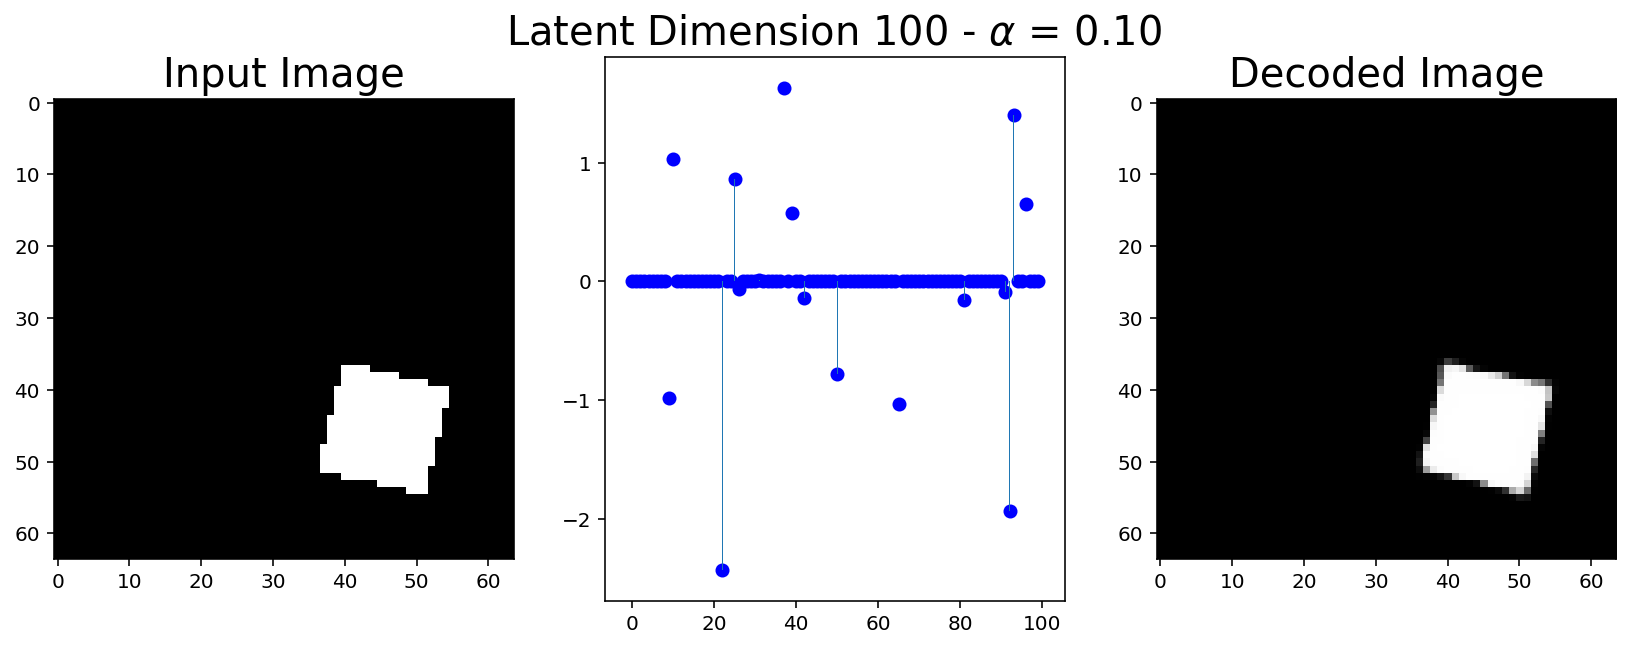

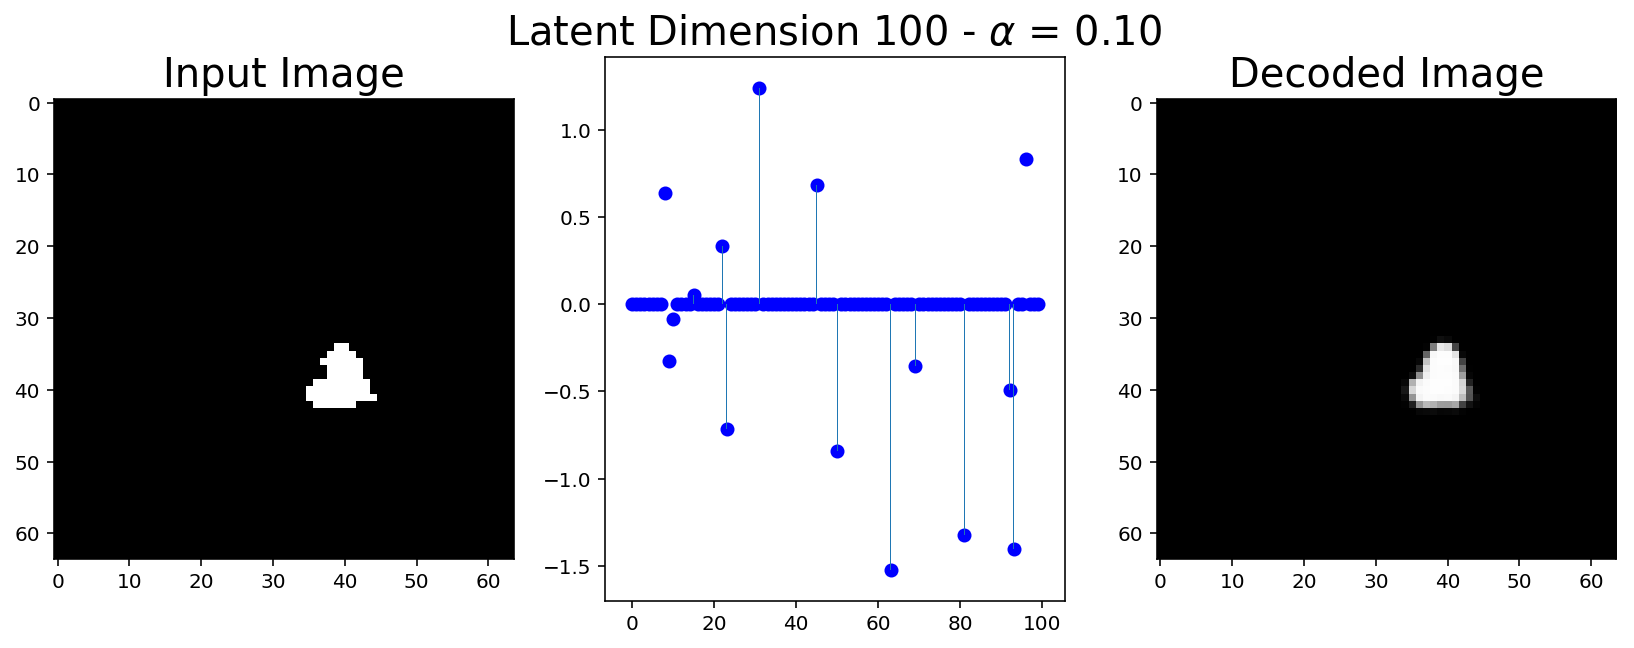

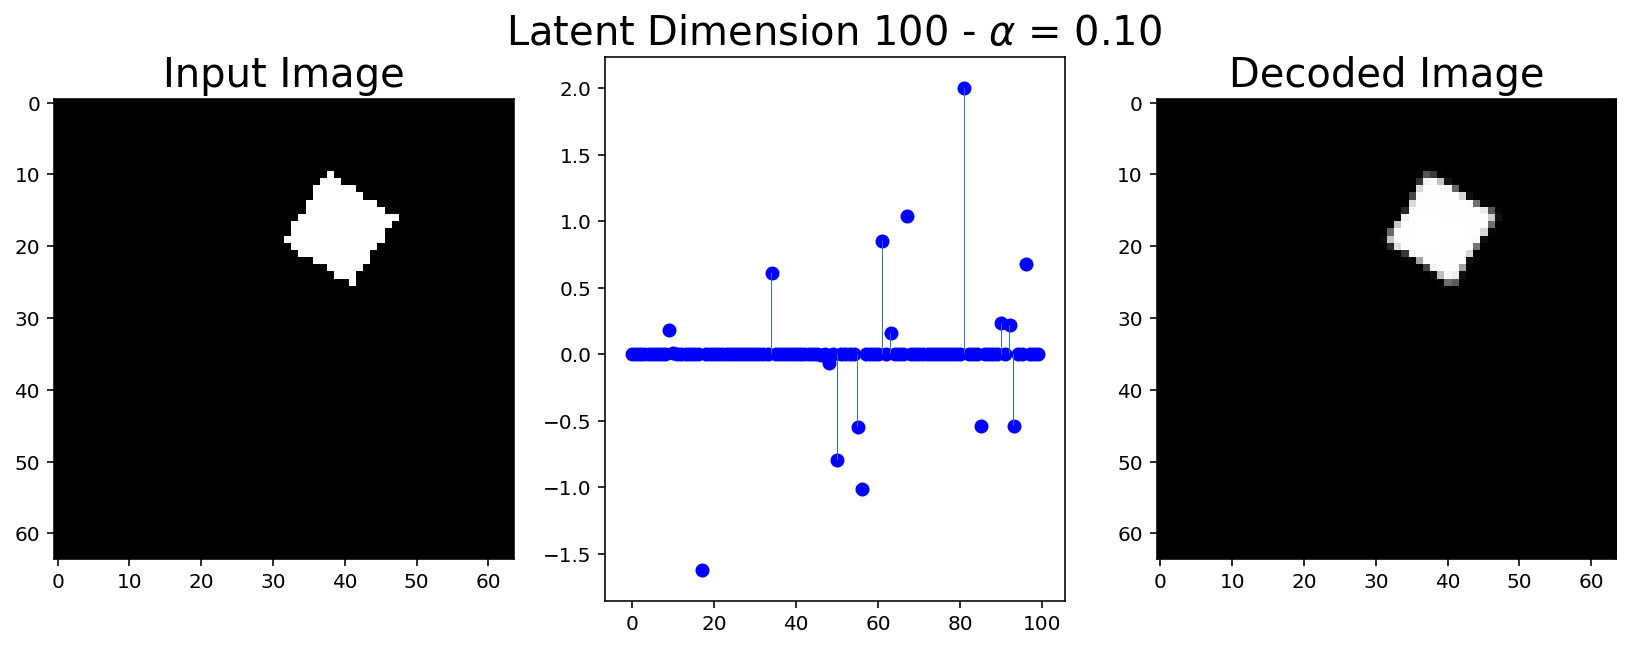

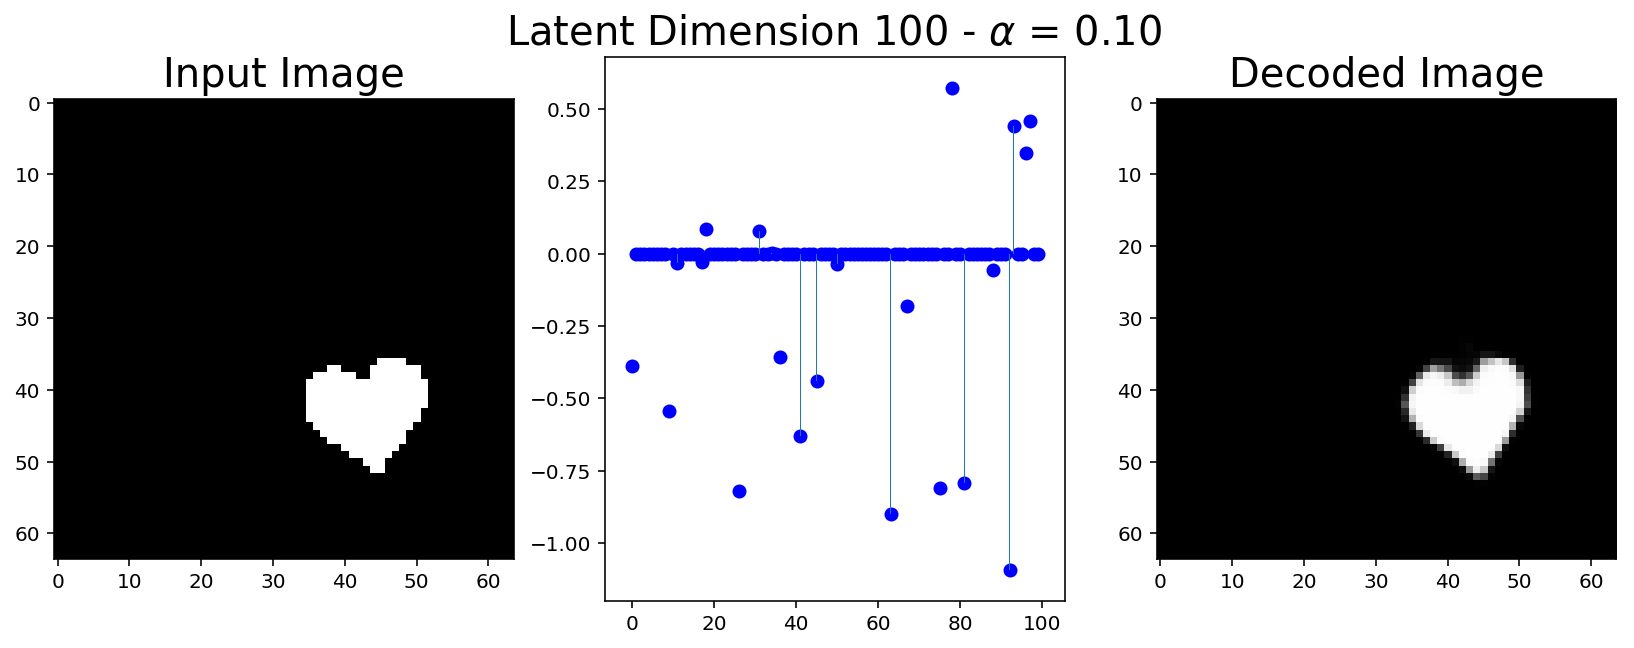

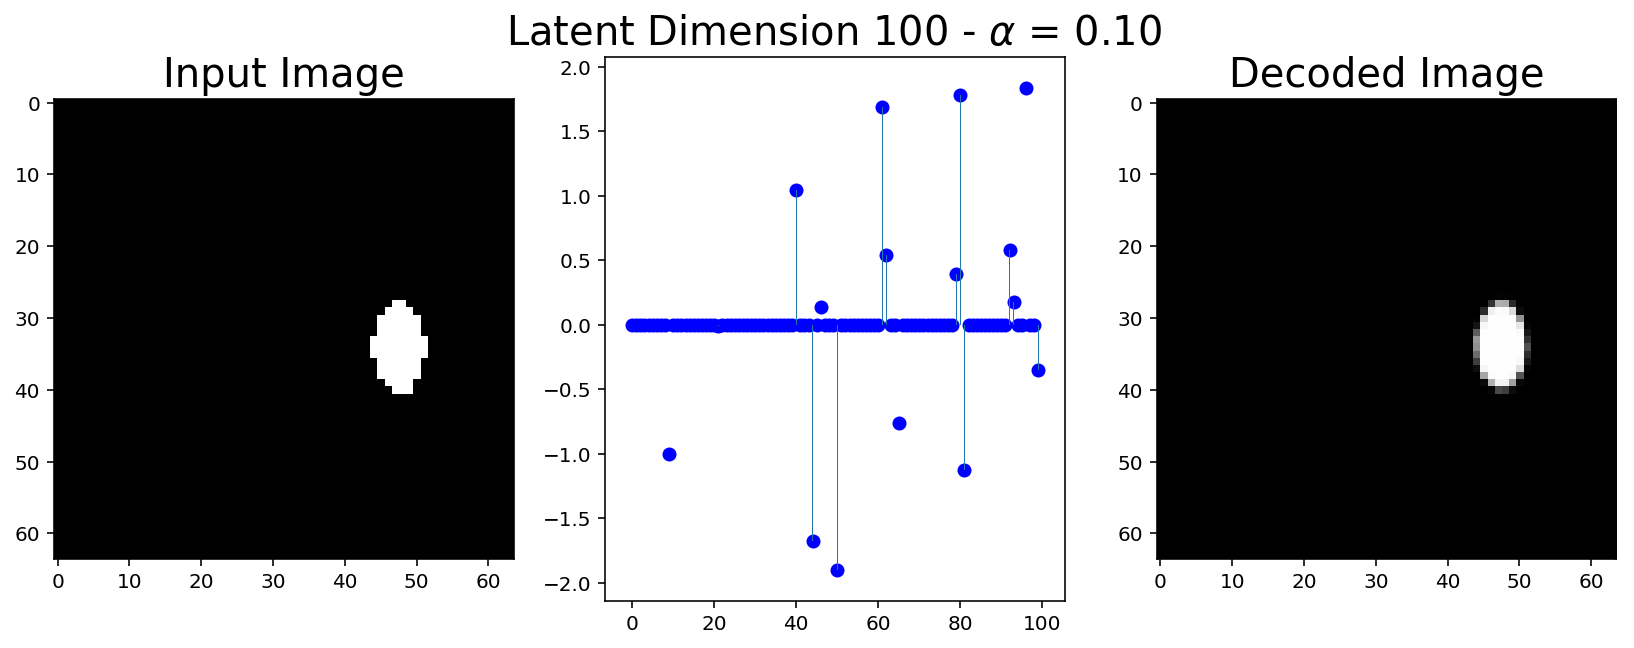

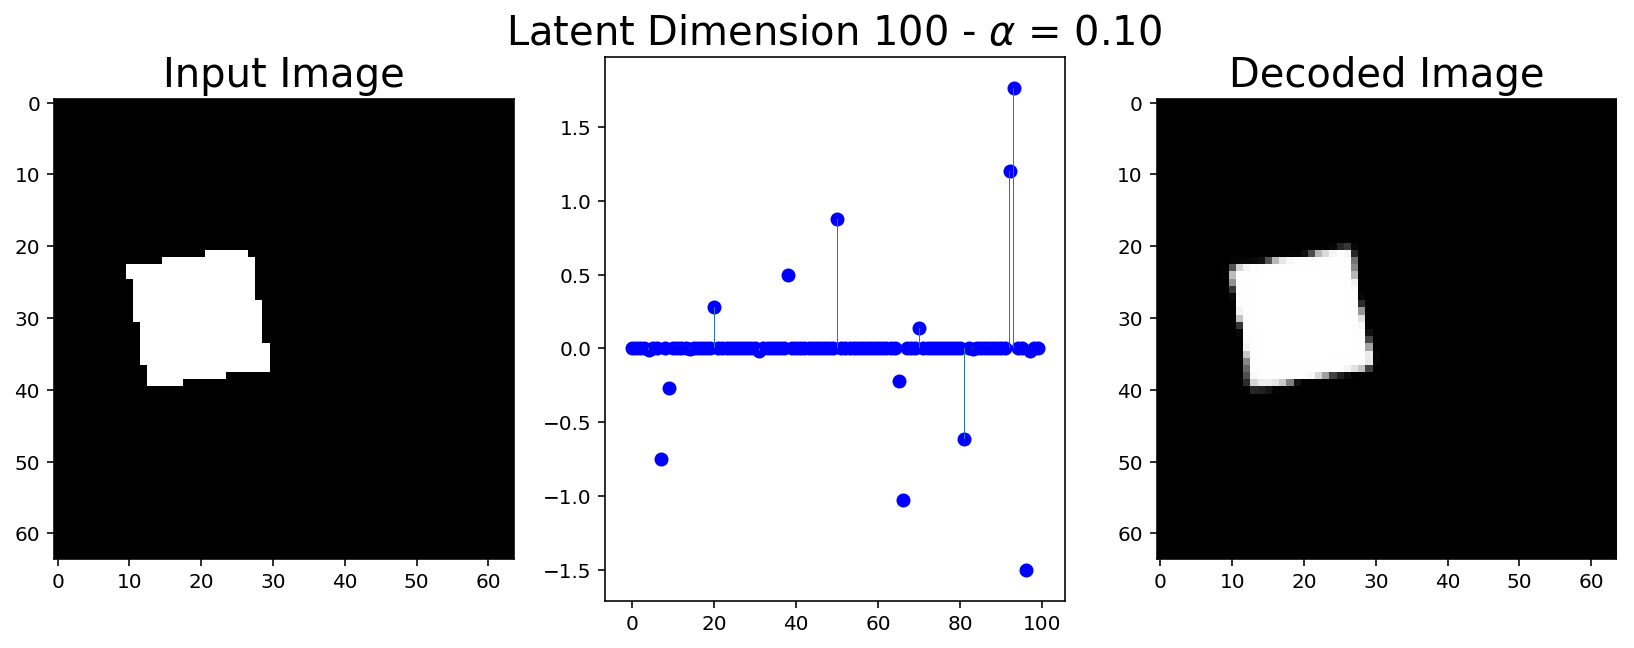

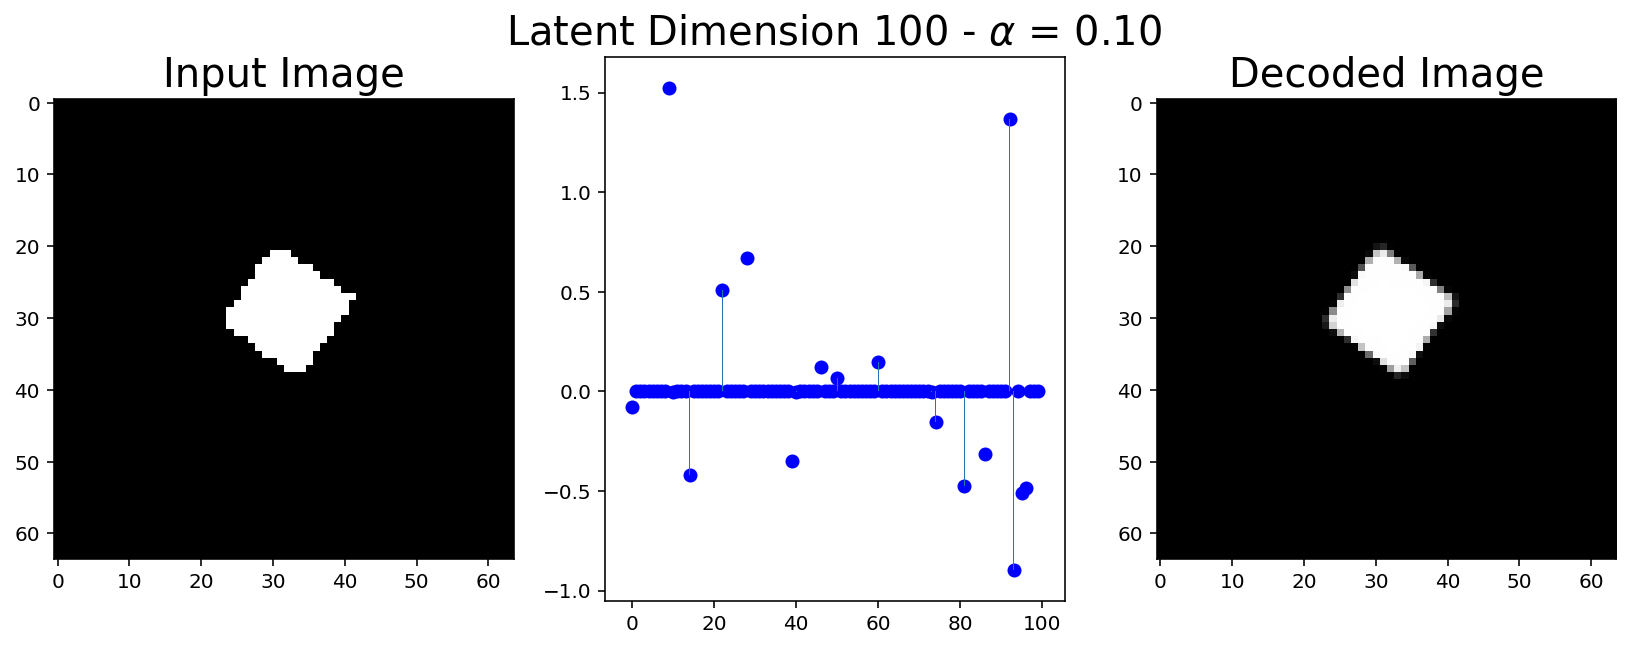

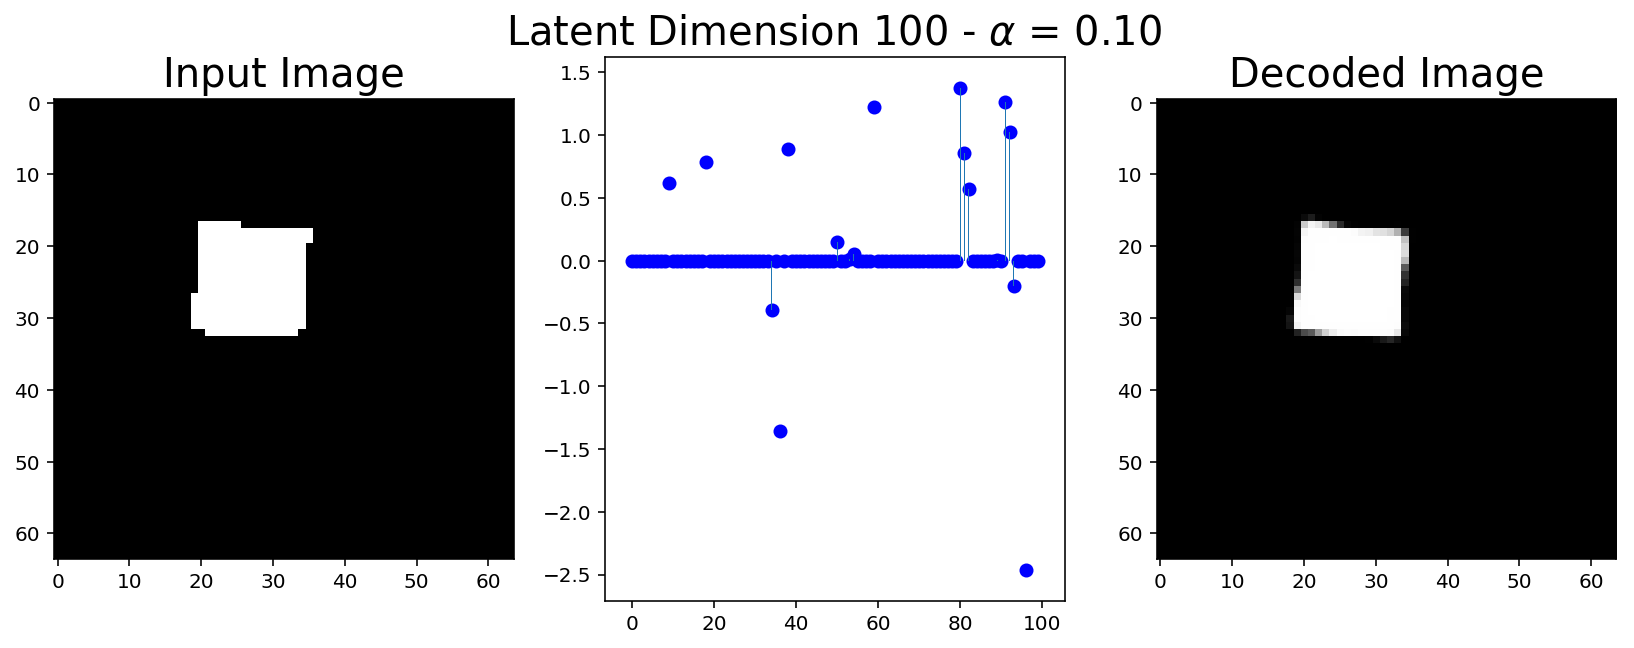

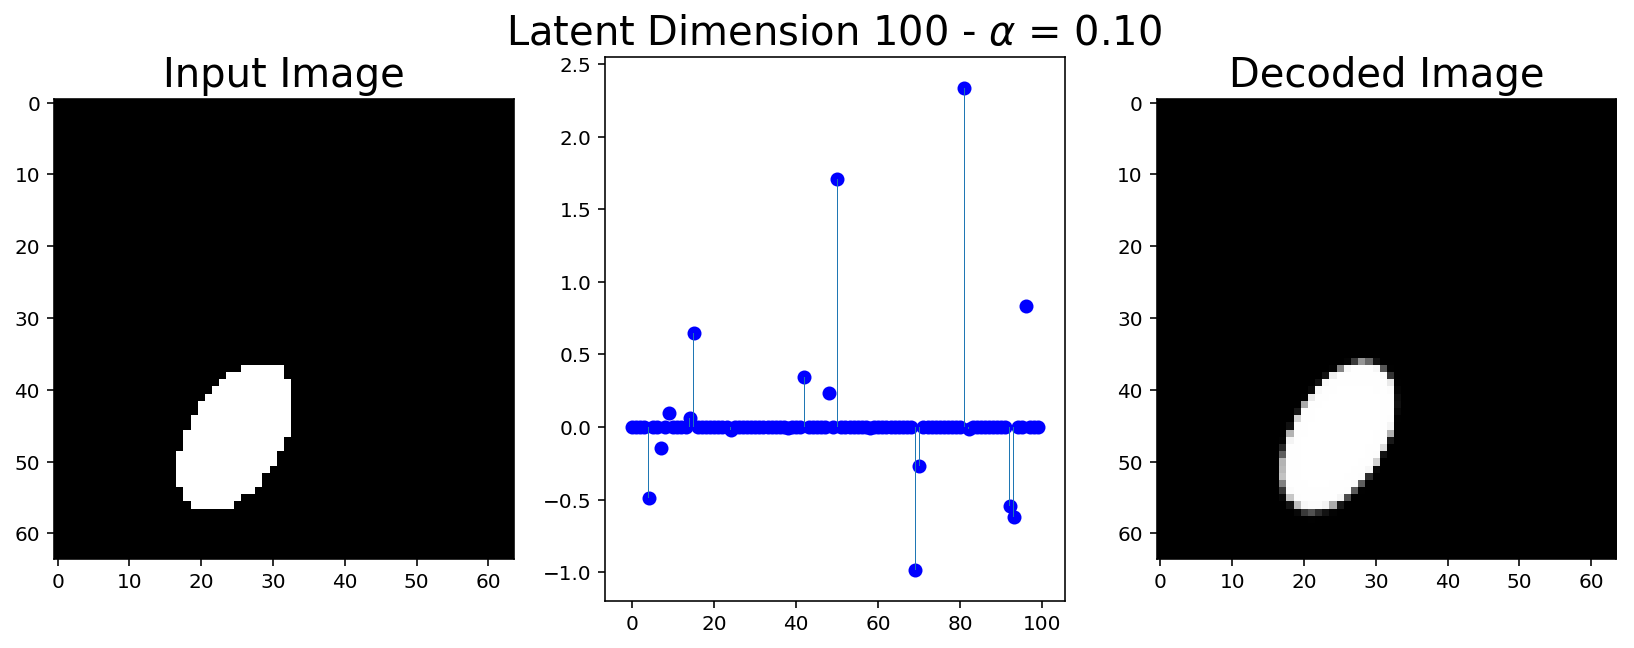

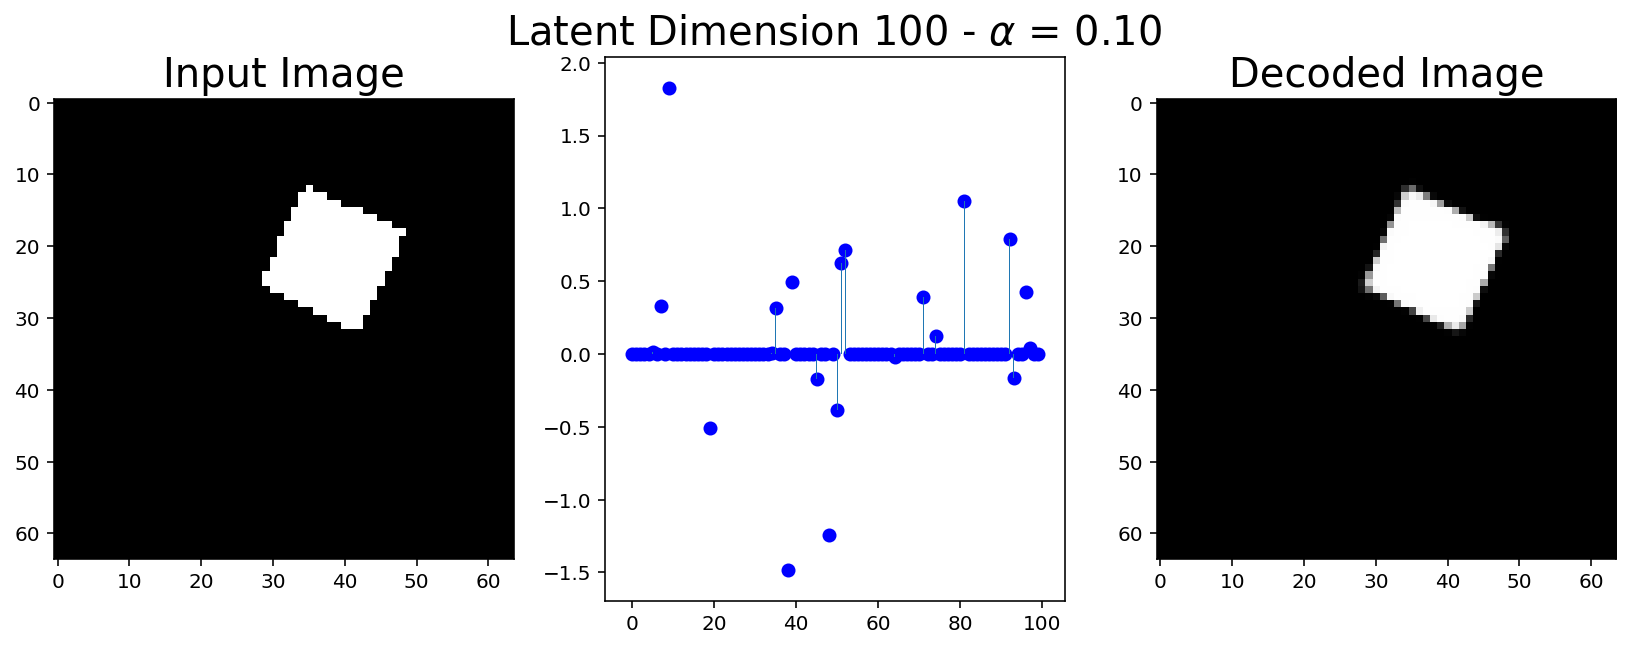

In [88]:
for i in range(10):
    plot_encoding(images[i][None,:], convvsc, 
                  model_params['latent_sz'], 
                  model_params['alpha'])

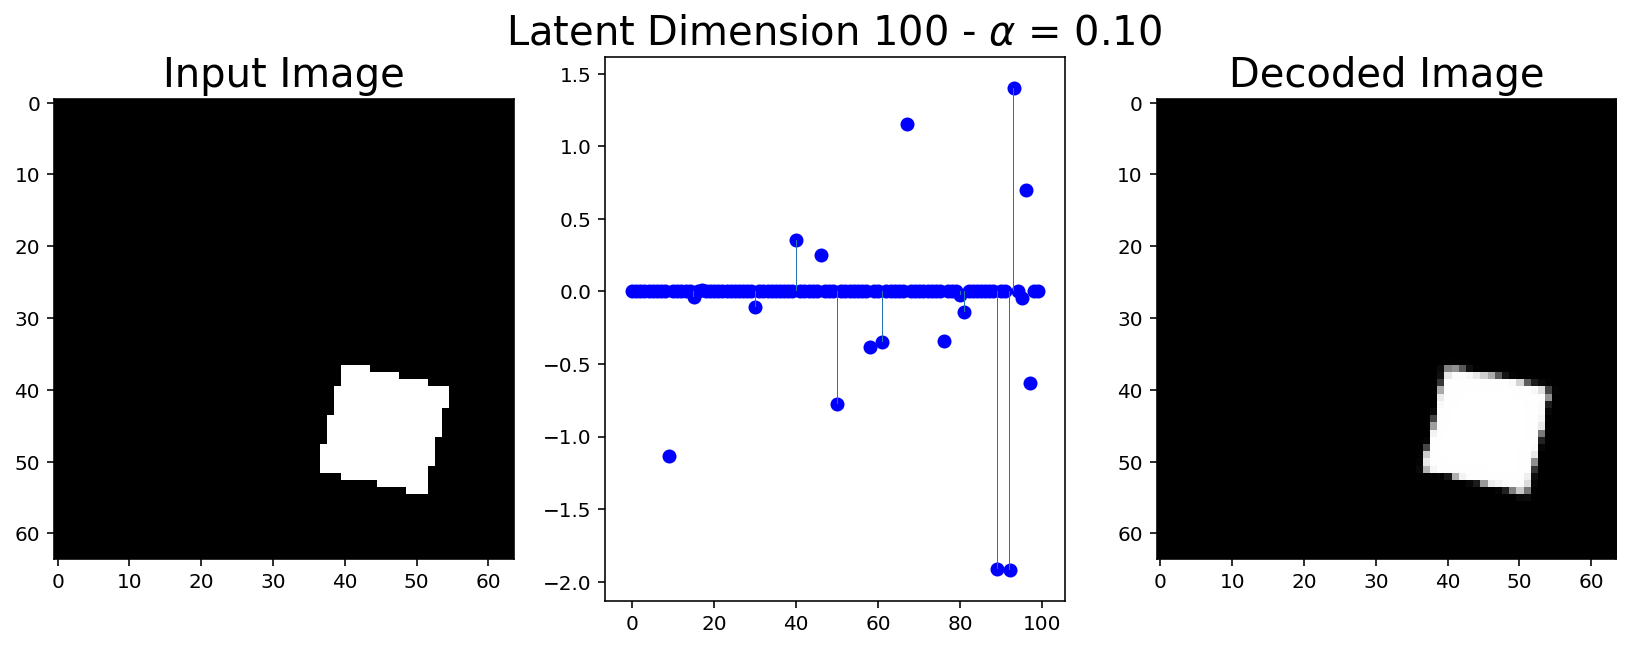

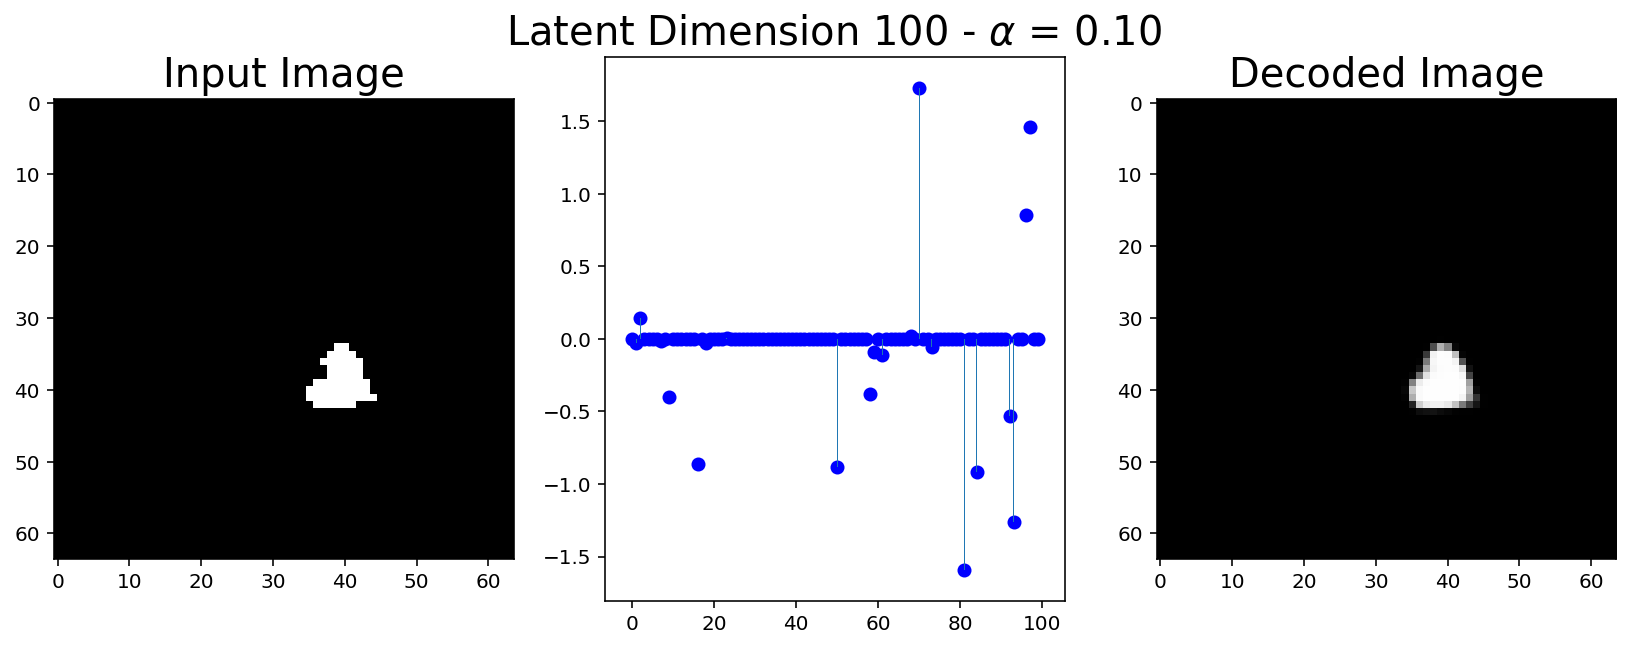

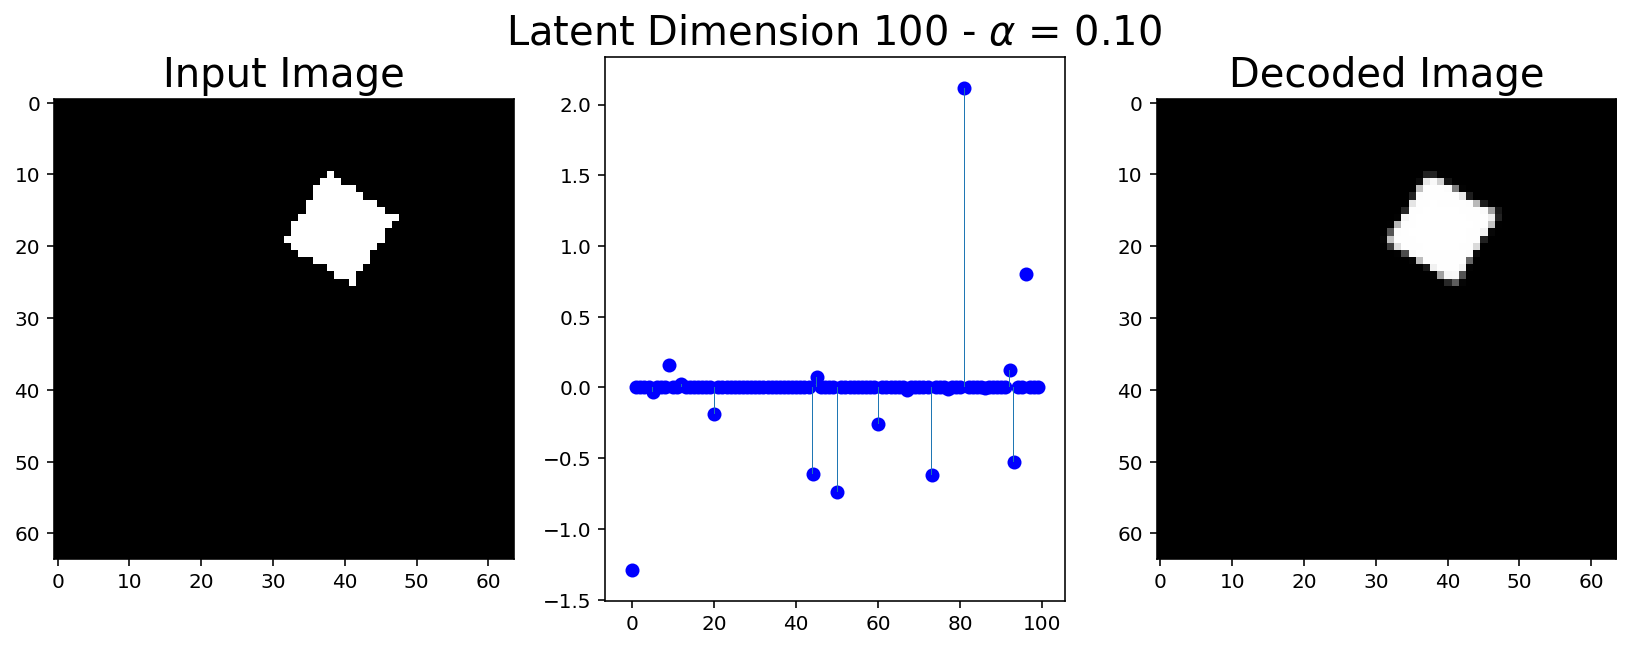

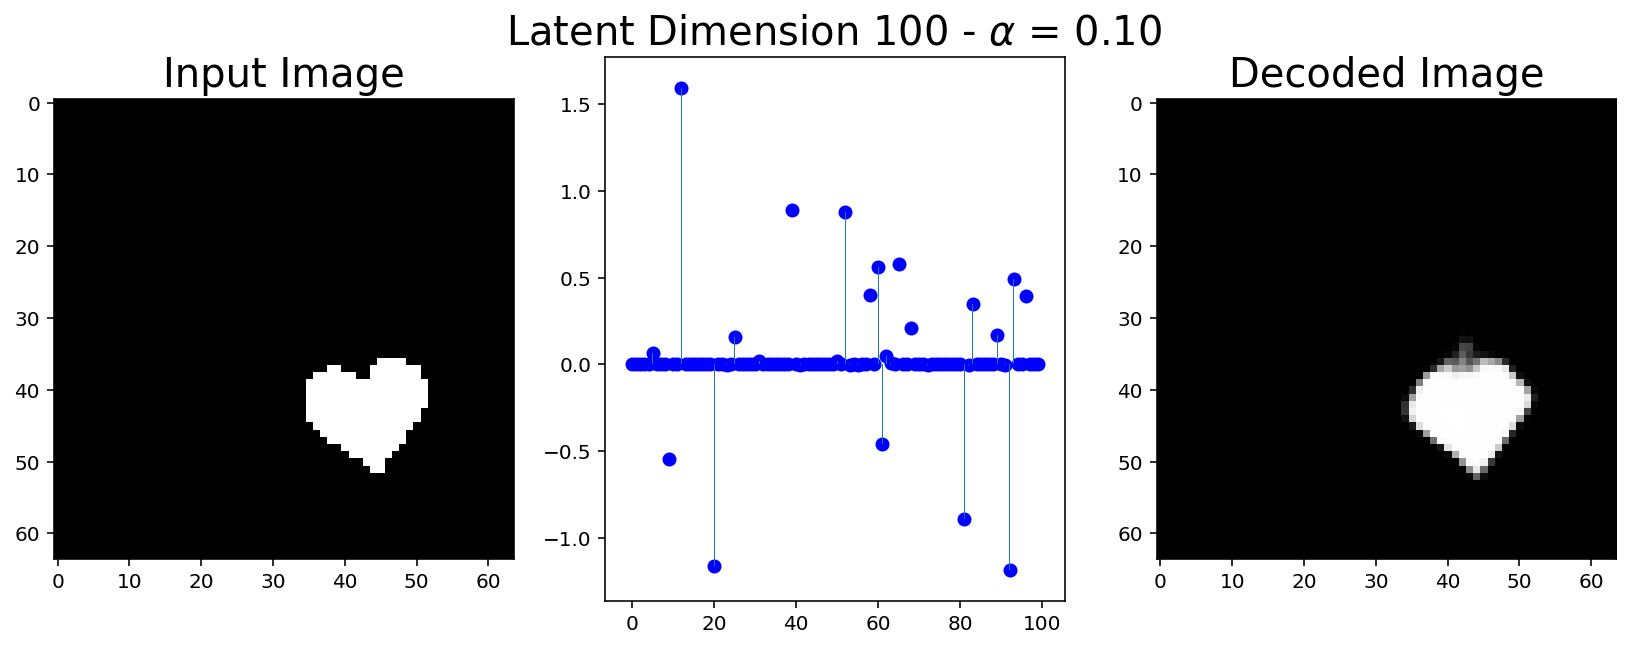

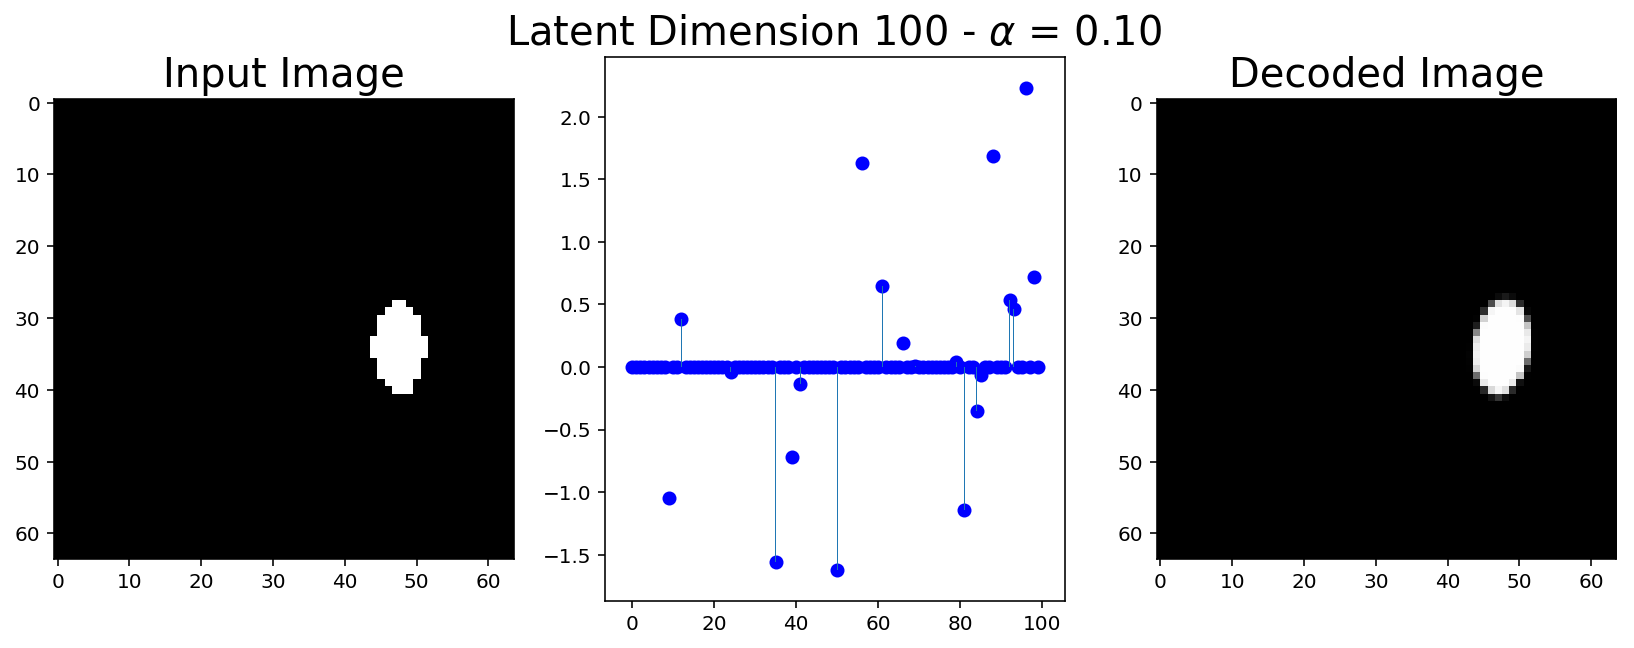

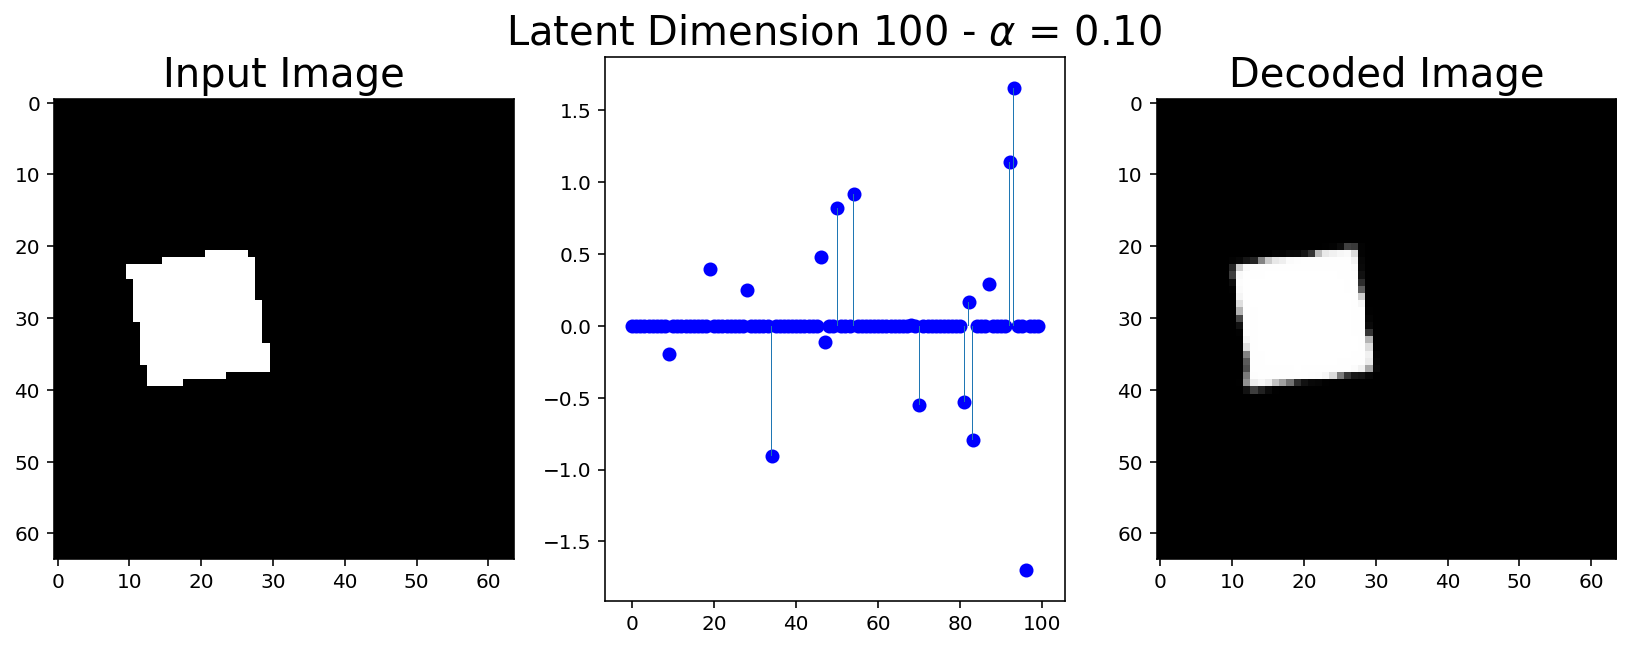

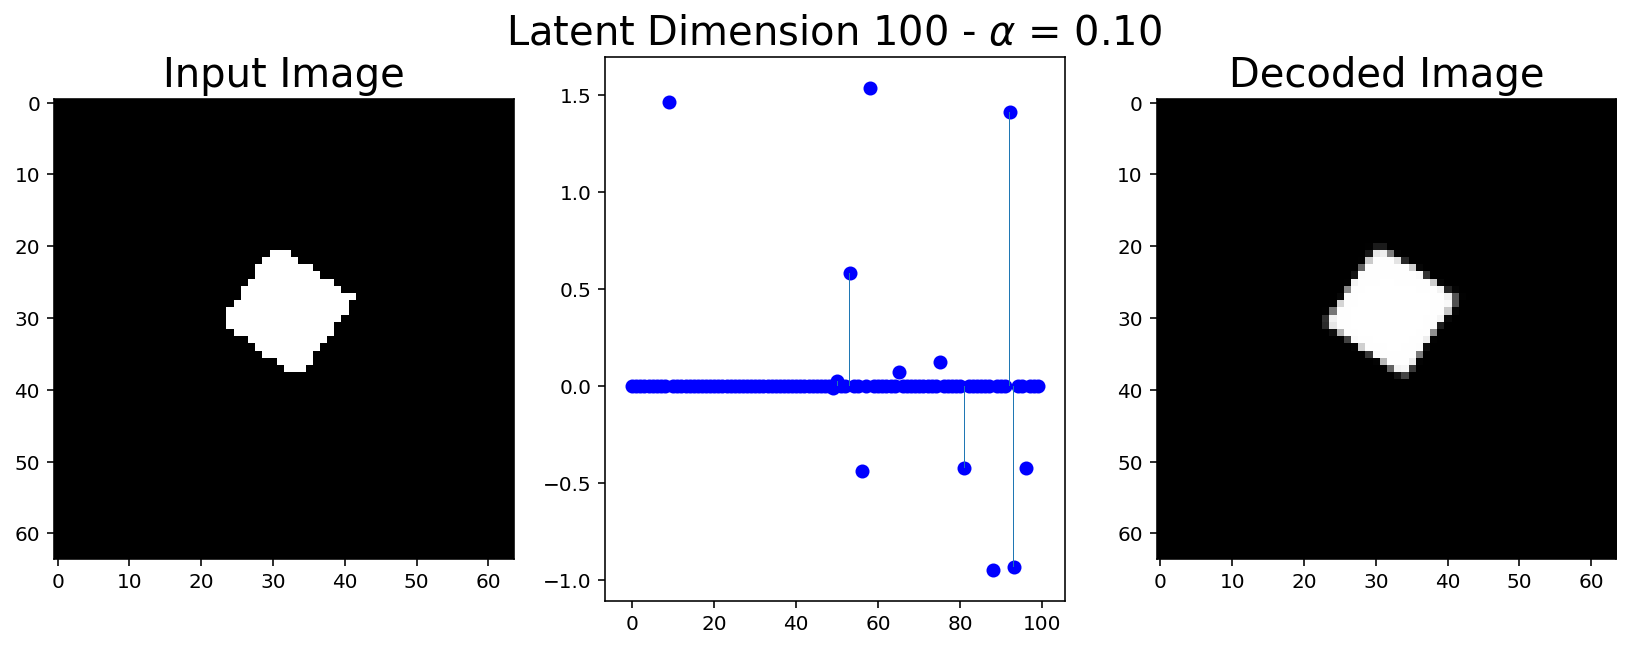

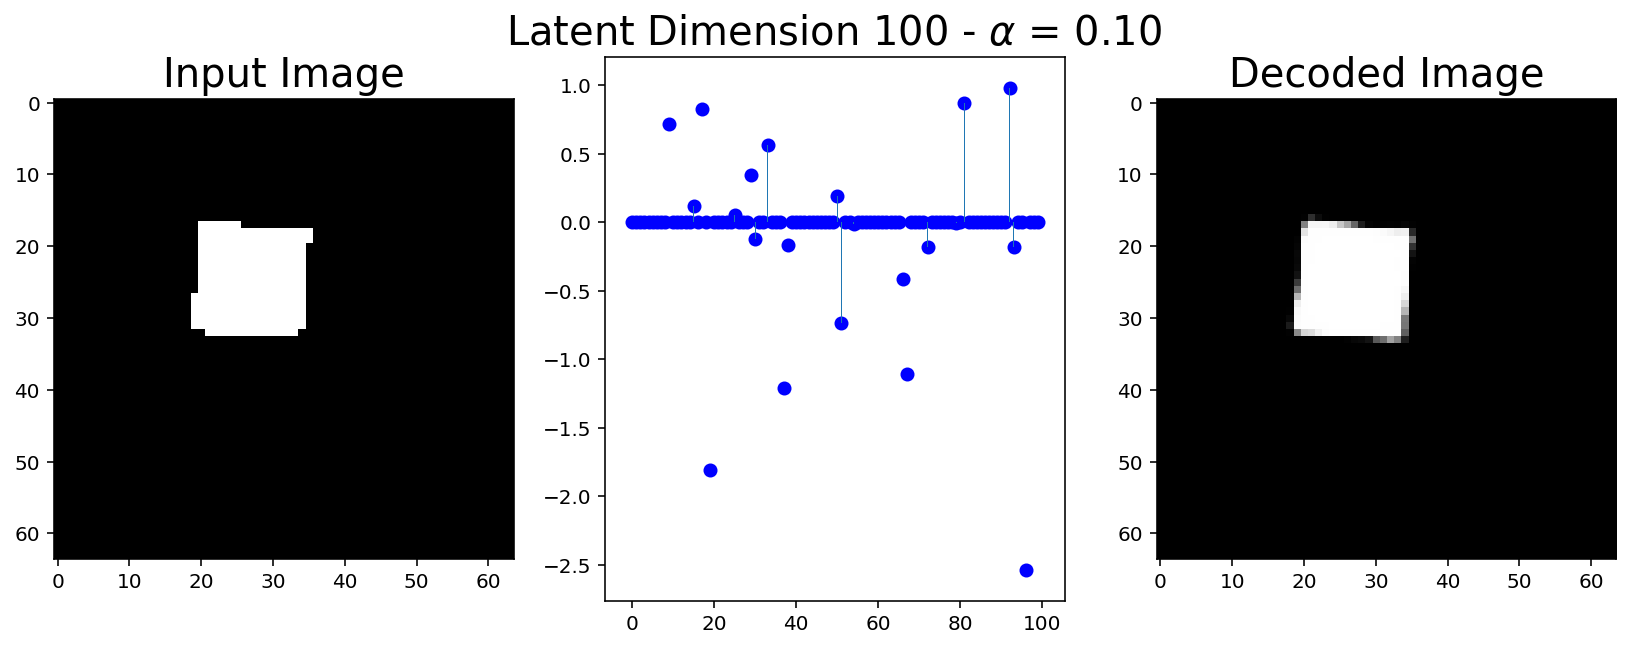

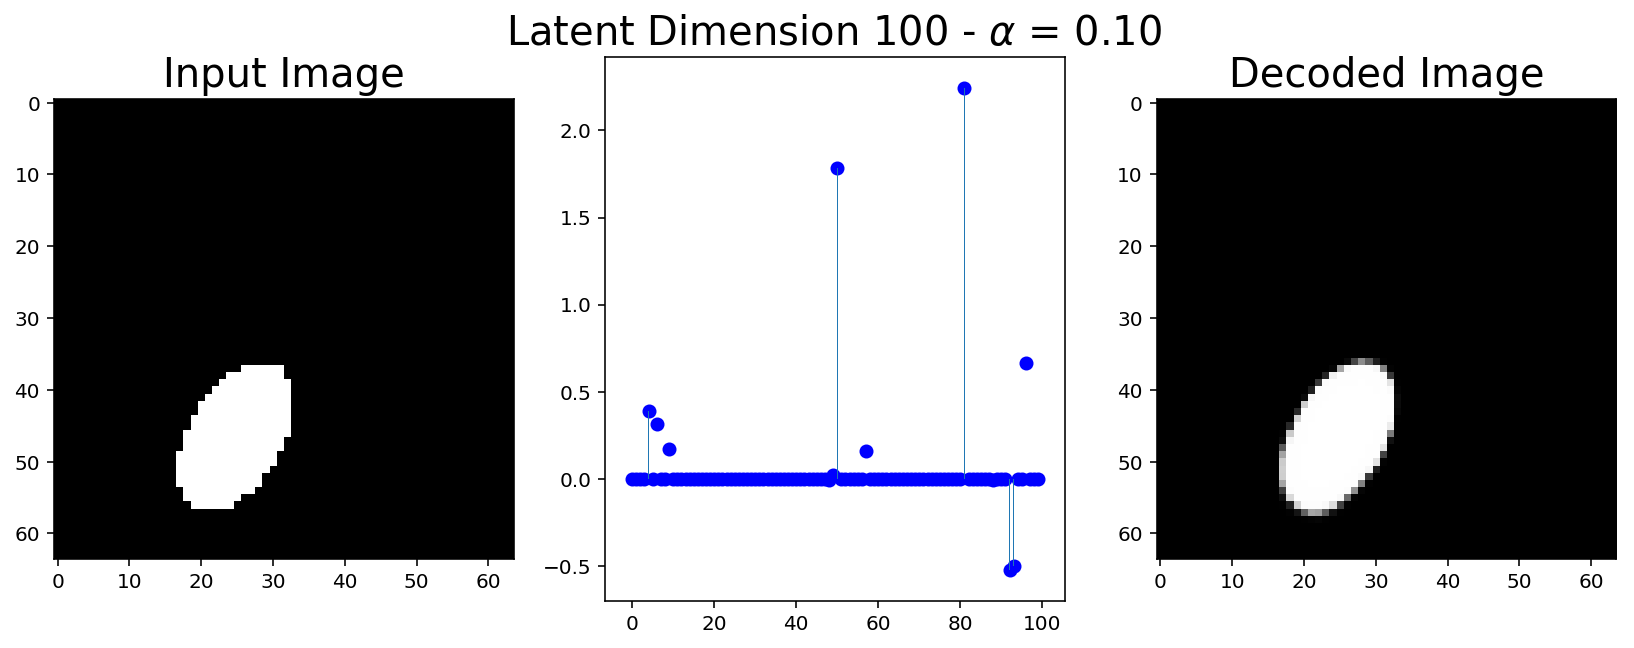

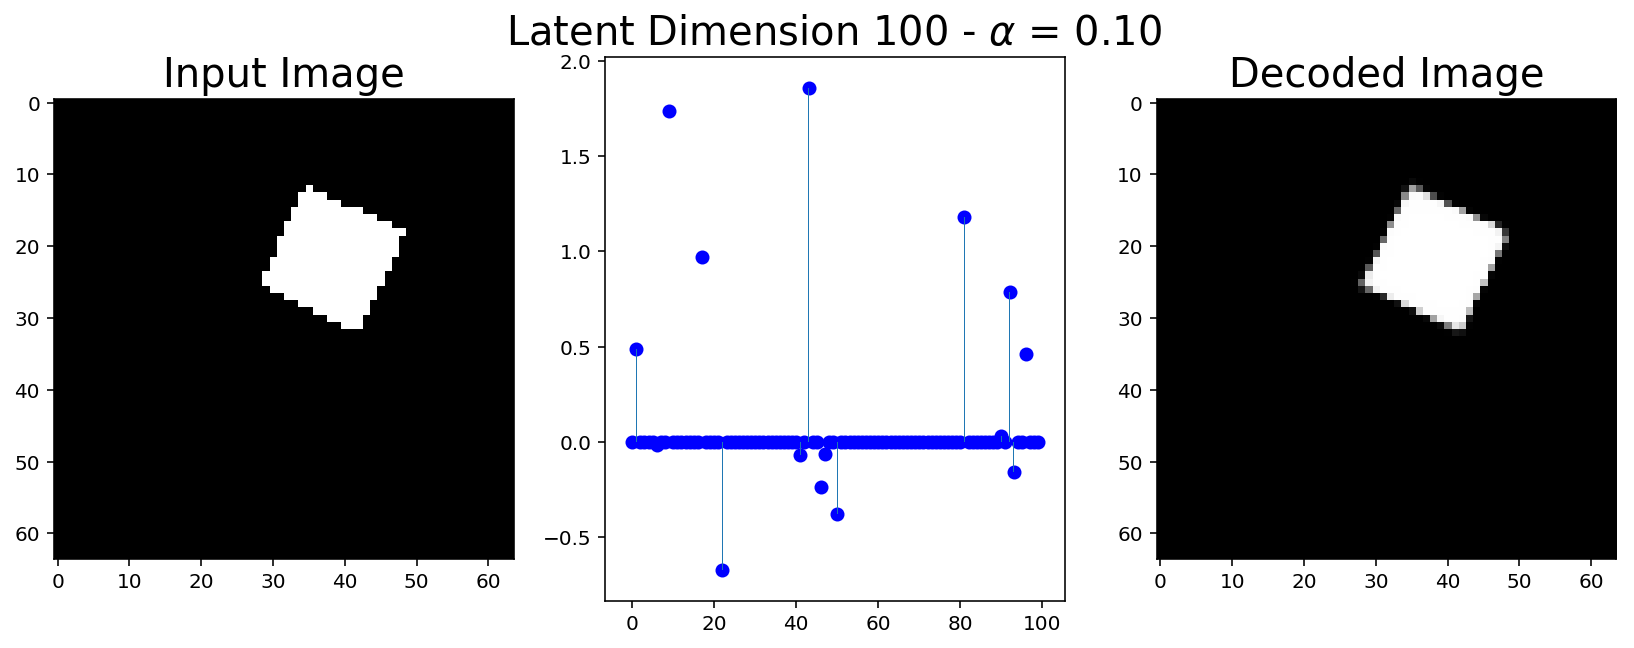

In [19]:
for i in range(10):
    plot_encoding(images[i][None,:], convvsc, 
                  model_params['latent_sz'], 
                  model_params['alpha'])

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import torchvision

def plot_image(img, ax, title):
    ax.imshow(np.transpose(img, (1,2,0)) , interpolation='nearest')
    ax.set_title(title, fontsize=20)
    
def to_numpy(image, vsc):
    return torchvision.utils.make_grid(
        image.view(1, vsc.channels, vsc.height, vsc.width)
    ).cpu().detach().numpy()
    
def plot_encoding(image, vsc, latent_sz, alpha, width=1/7):
    image = vsc.transform(image).to(vsc.device)
    decoded, mu, logvar, logspike = vsc.model.forward(image)
    z = vsc.model.reparameterize(mu, logvar, logspike)
    img = vsc.inverse_transform(vsc.model.decode(z))
    z = z.cpu().detach().numpy()[0]
    
    fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, figsize=(9,4))
    
    plot_image(to_numpy(image, vsc), ax0, 'Input Image')
    
    ax1.bar(np.arange(latent_sz), height=z, width=width, align='center')
    ax1.scatter(np.arange(latent_sz), z, color='blue')
    ax1.set_title(r"Latent Dimension %d - $\alpha$ = %.2f " % \
                  (latent_sz, alpha), fontsize=14)
    
    plot_image(to_numpy(img, vsc), ax2, 'Decoded Image')
    plt.subplots_adjust(hspace=0.5)

In [50]:
import random

def plot_horizontal_traversal(image, vsc, latent_sz, length, 
                              delta, threshold=1e-4, plot_all=False, 
                              plot_list=None, width=1/4, n_indices=15):
    image = vsc.transform(image).to(vsc.device)
    decoded, mu, logvar, logspike = vsc.model.forward(image)
    z = vsc.model.reparameterize(mu, logvar, logspike)
    img = vsc.inverse_transform(vsc.model.decode(z))
    z_ = z.cpu().detach().numpy()[0]
    
    plt.bar(np.arange(latent_sz), height=z_, width=width, align='center')
    plt.scatter(np.arange(latent_sz), z_, color='blue')
    plt.show()
    
    non_zero = [i for i in range(latent_sz) if np.abs(z_[i]) > threshold]
    inds = np.random.choice(non_zero, n_indices)
    print(inds)
    
    if not plot_all:
        non_zero = inds # [ind]
    if plot_list:
        non_zero = plot_list
        
    print(non_zero)
    
    hor_traversal = []
    for ind in non_zero:
        images = []
        z1 = z.clone()
        for i in range(length):
            img = to_numpy(vsc.model.decode(z1), vsc)
            img = np.transpose(img, (1,2,0))
            img[:,0] = 1
            img[:,-1] = 1
            img[0,:] = 1
            img[-1,:] = 1
            images.append(img)
            z1[0, ind] = z1[0, ind] + delta if z[0,ind] < 0 else z1[0, ind] - delta

        hor_traversal.append(np.concatenate(images, axis=1))
    traversal = np.concatenate(hor_traversal, axis=0)
    plt.figure(figsize=(14,24))
    plt.axis('off')
    plt.imshow(traversal)
    plt.show()
#     return traversal

In [ ]:
# 9 epochs 
# image[0]
# images[2] : 3, 5, 9

In [ ]:
# 18 epochs
# image[-1]

# 9: rotation
# 14: change to circle
# 92: change to diamond
# 93: change to diamond
# 97: change to oval
# 96: change of point

# negative
# 9: change to diamond
# 50: change to square

In [48]:
32 - 3

29

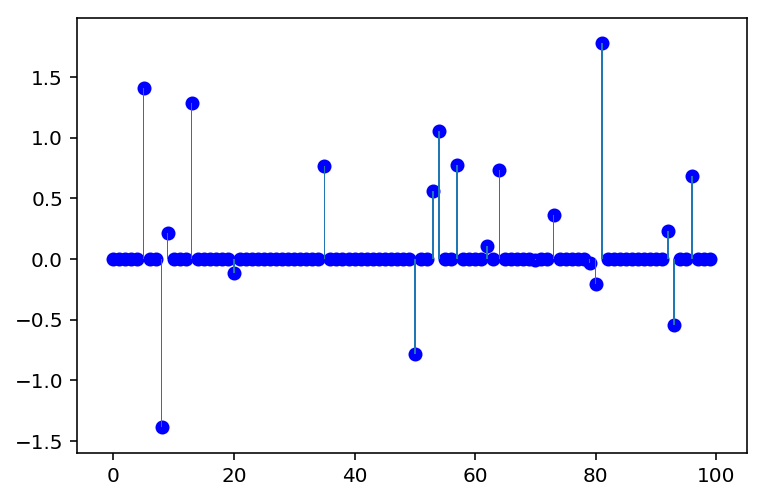

[92 13 92 73 53 93 13 79 79 50 70 50 80 57 62 57 81  9 73]
[81, 93, 96]


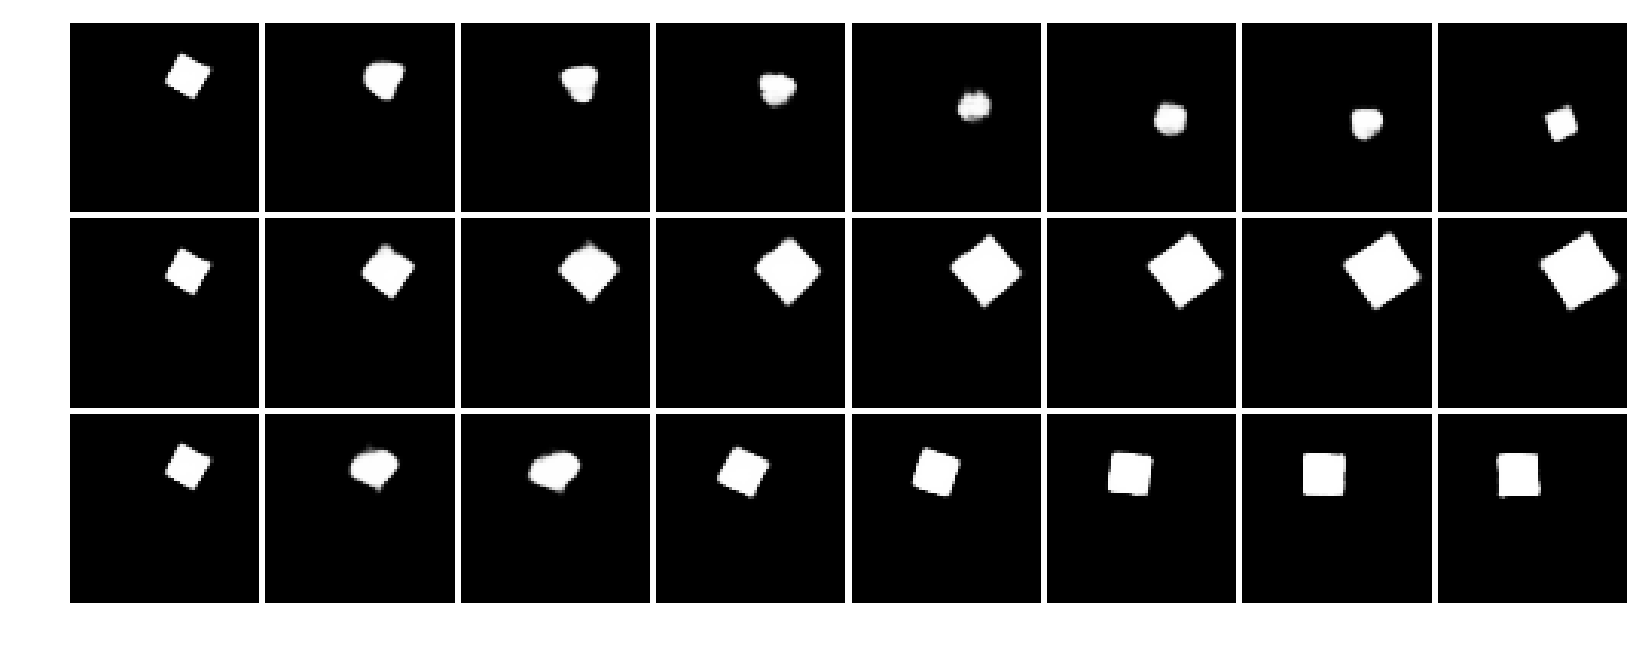

In [52]:
# 9 epochs
plot_horizontal_traversal(images[2][None,:], convvsc, 
                          model_params['latent_sz'], length=8, 
                          delta=0.5, threshold=0.01,
                          plot_all=False, 
                          plot_list=[81, 93, 96],
                          n_indices=19)

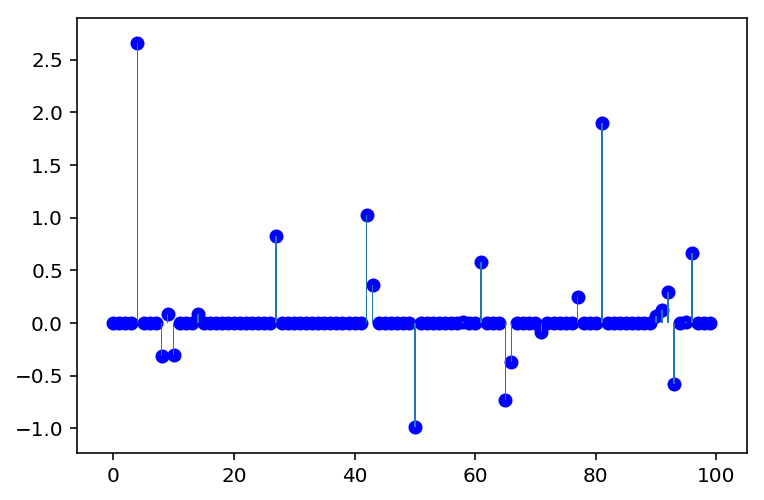

[91 14 61 96 92 77 65 65 96 71  8 91 27 81 65 96 10 71 65]
[81, 93, 96]


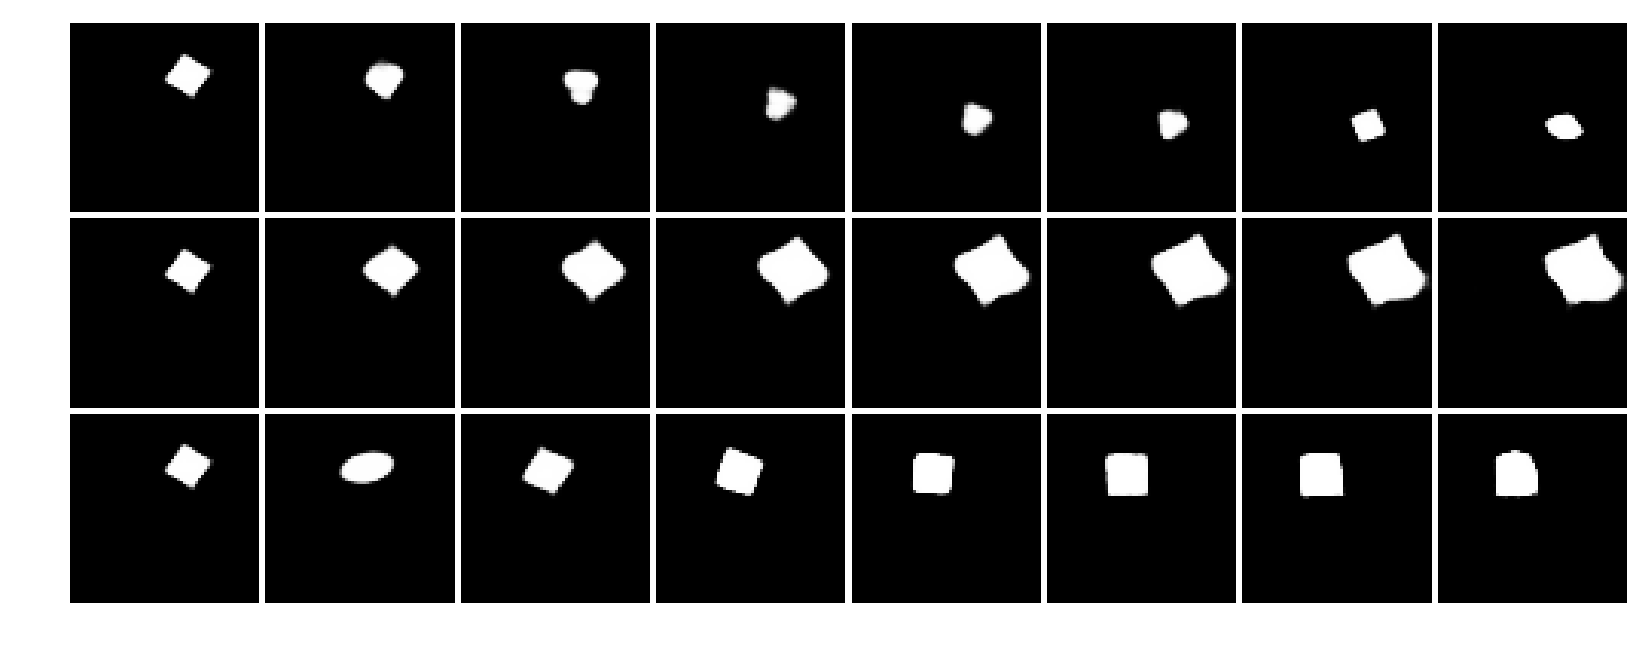

In [81]:
# 9 epochs
plot_horizontal_traversal(images[2][None,:], convvsc, 
                          model_params['latent_sz'], length=8, 
                          delta=0.7, threshold=0.01,
                          plot_all=False, 
                          plot_list=[81, 93, 96],
                          n_indices=19)

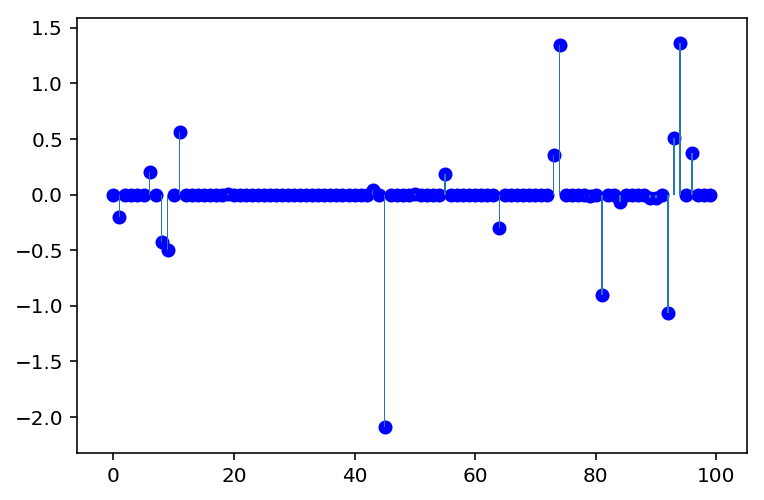

[81 45 93 96  1  6 43 43 11 64 74  6 74  6  9 43 55 55 81]
[9, 50]


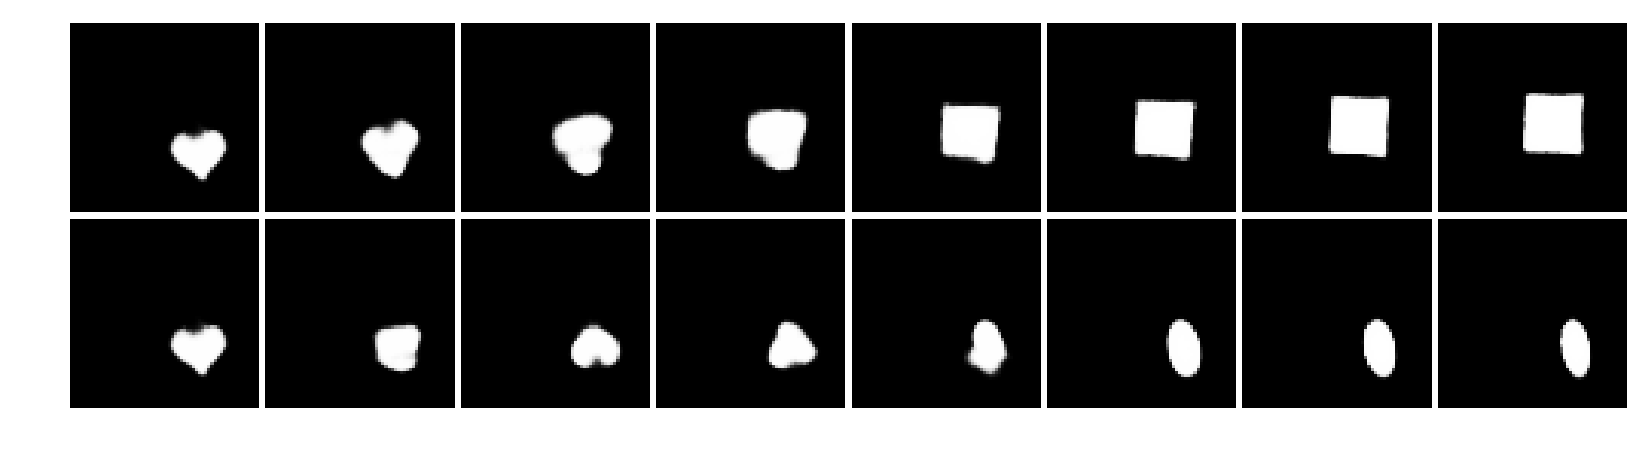

In [59]:
# 9 epochs
plot_horizontal_traversal(images[3][None,:], convvsc, 
                          model_params['latent_sz'], length=8, 
                          delta=0.5, threshold=0.01,
                          plot_all=False, 
                          plot_list=[9, 50],
                          n_indices=19)

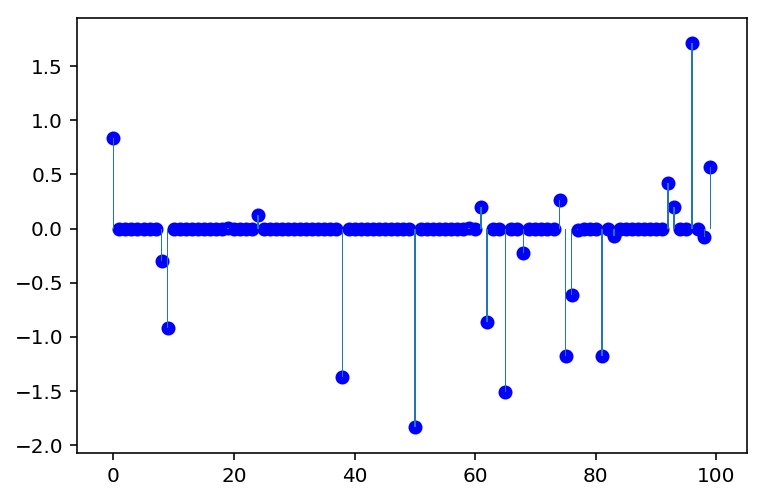

[98 75 68 65 76  8 38 38  8 83 81 96 93 62 92 76 38 92 92]
[9, 50]


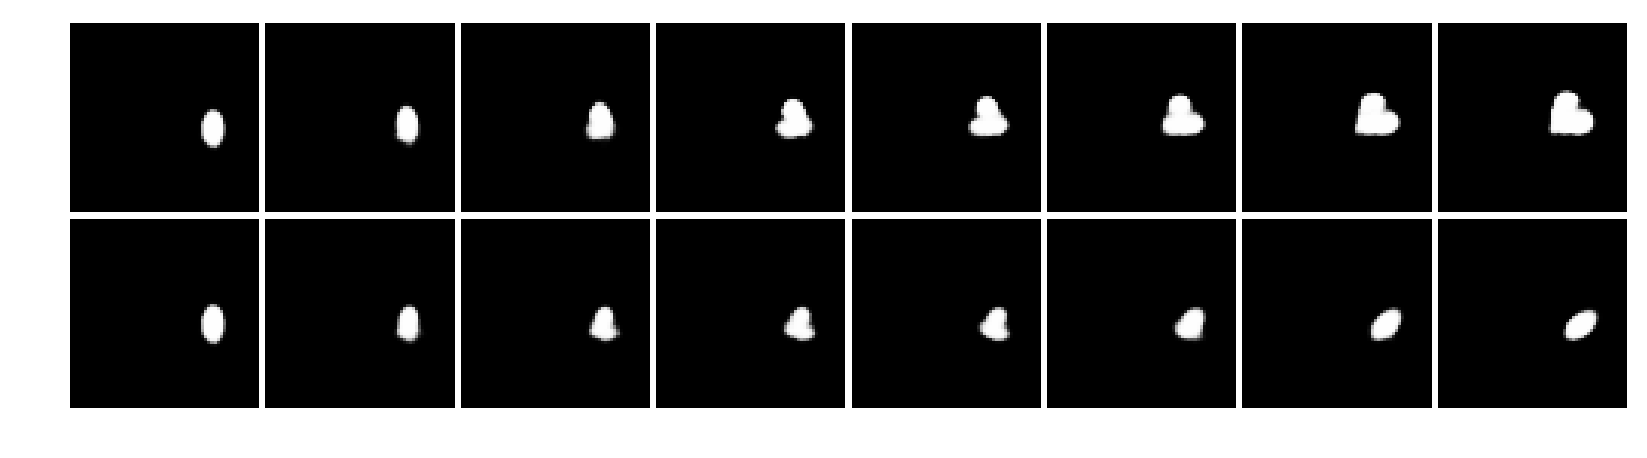

In [67]:
# 9 epochs
plot_horizontal_traversal(images[4][None,:], convvsc, 
                          model_params['latent_sz'], length=8, 
                          delta=0.25, threshold=0.01,
                          plot_all=False, 
                          plot_list=[9, 50],
                          n_indices=19)

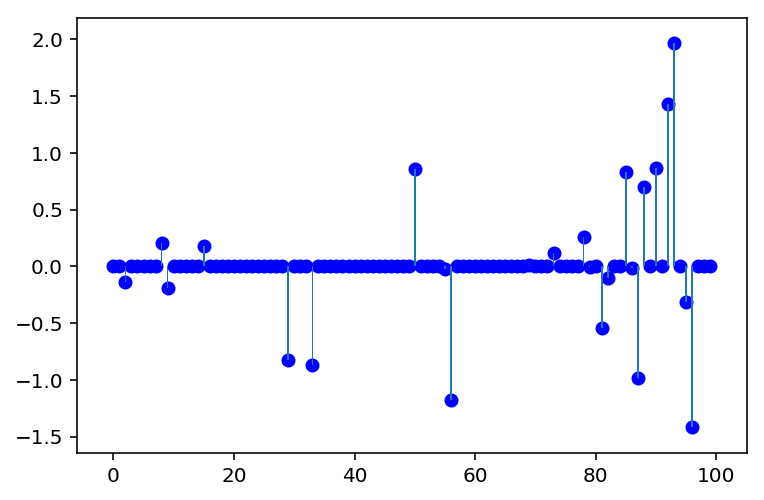

[33 82 88 96 95 87  9 33 96 69  8 73 88 33 50  9  9 87 56]
[9, 81]


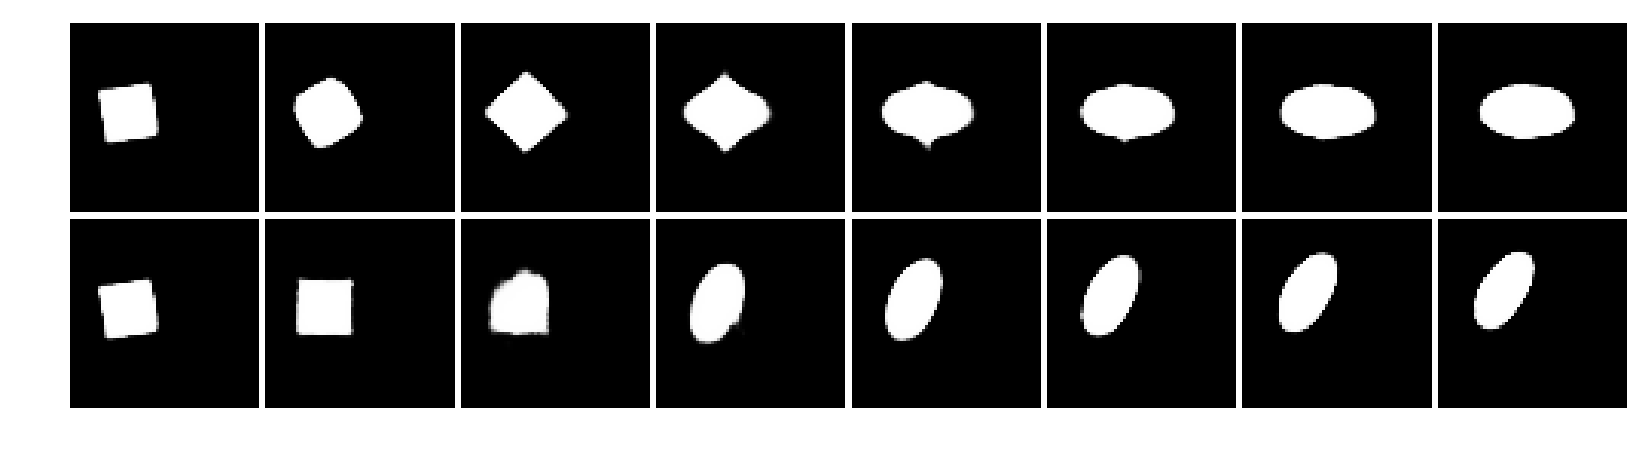

In [74]:
# 9 epochs
plot_horizontal_traversal(images[5][None,:], convvsc, 
                          model_params['latent_sz'], length=8, 
                          delta=0.6, threshold=0.01,
                          plot_all=False, 
                          plot_list=[9, 81],
                          n_indices=19)

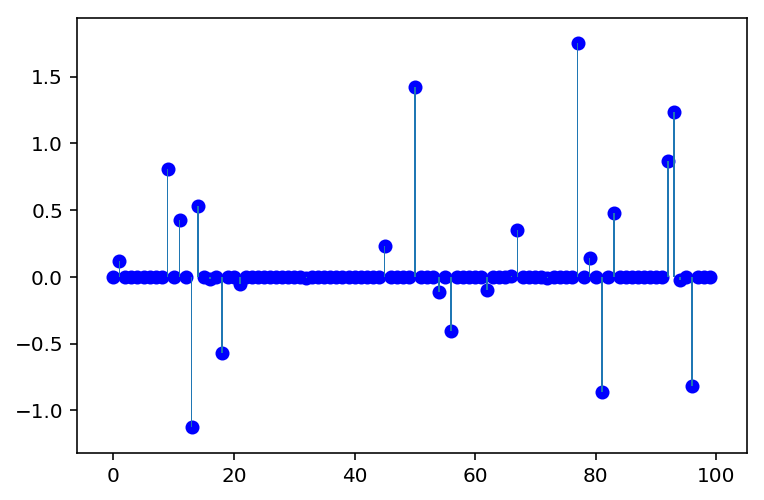

[11  9  3 81 72 54 83 94  3 50 32 66 45 92 77 62 81 14 81]
[92]


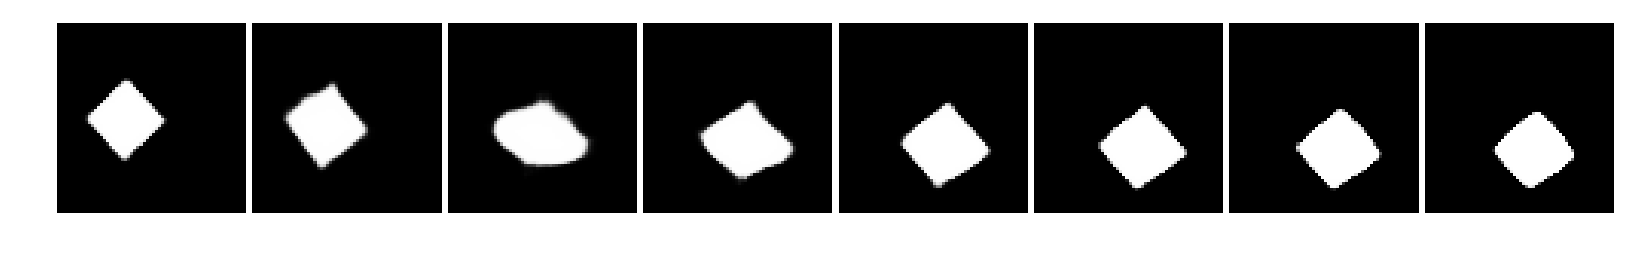

In [115]:
# 12 epochs
plot_horizontal_traversal(images[-3][None,:], convvsc, 
                          model_params['latent_sz'], length=8, 
                          delta=.8, threshold=0.0001,
                          plot_all=True, 
                          plot_list=[92],
                          n_indices=19)

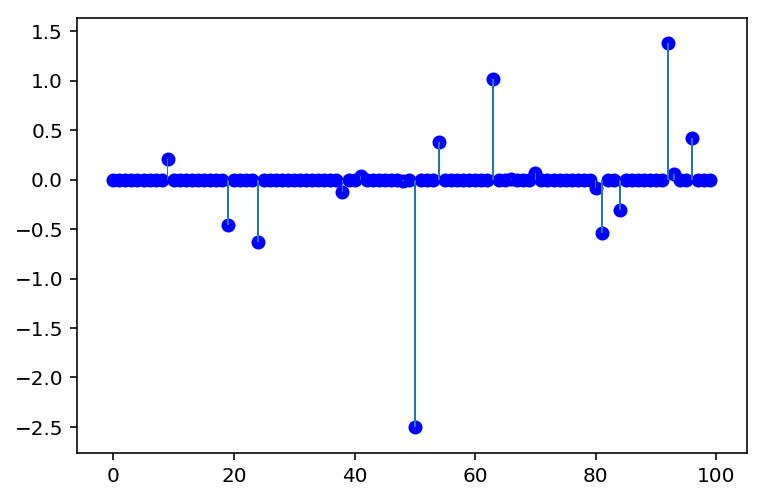

[93 80 98 19 81 48 24  2  9 93 57 92 54 54  0 84  2  2  9]
[0, 2, 9, 19, 24, 38, 41, 48, 50, 54, 57, 63, 66, 70, 80, 81, 84, 92, 93, 96, 98]


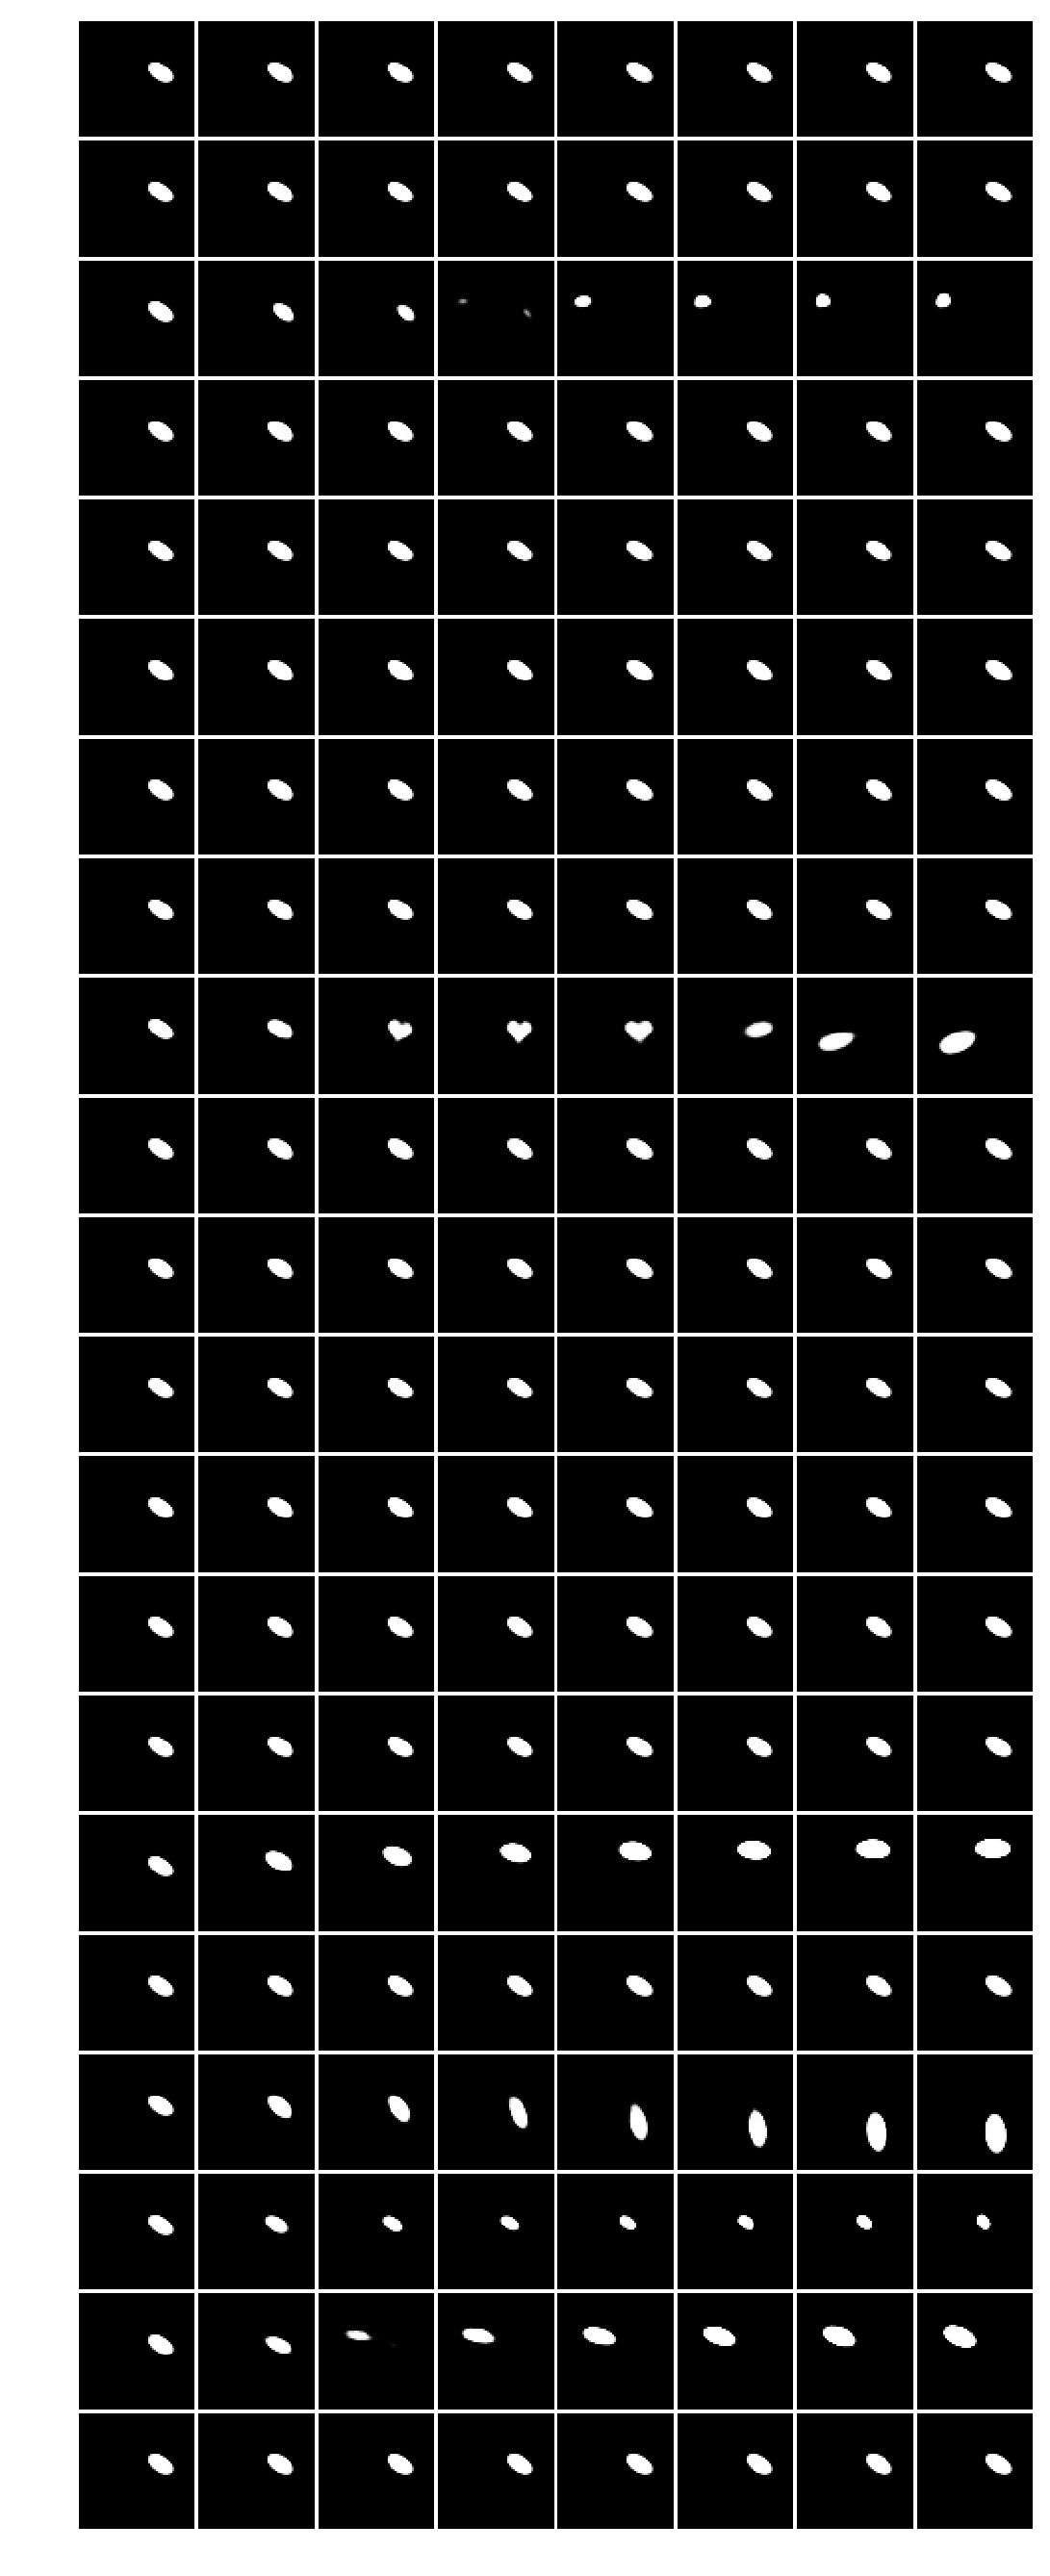

In [117]:
plot_horizontal_traversal(images[-4][None,:], convvsc, 
                          model_params['latent_sz'], length=8, 
                          delta=0.5, threshold=0.0001,
                          plot_all=True, 
                          plot_list=None,
                          n_indices=19)

## Stack traversals

In [121]:
import random

def plot_horizontal_traversal(image, vsc, latent_sz, length, 
                              delta, threshold=1e-4, plot_all=False, 
                              plot_list=None, width=1/4, n_indices=15):
    image = vsc.transform(image).to(vsc.device)
    decoded, mu, logvar, logspike = vsc.model.forward(image)
    z = vsc.model.reparameterize(mu, logvar, logspike)
    img = vsc.inverse_transform(vsc.model.decode(z))
    z_ = z.cpu().detach().numpy()[0]
    
#     plt.bar(np.arange(latent_sz), height=z_, width=width, align='center')
#     plt.scatter(np.arange(latent_sz), z_, color='blue')
#     plt.show()
    
    non_zero = [i for i in range(latent_sz) if np.abs(z_[i]) > threshold]
    inds = np.random.choice(non_zero, n_indices)
#     print(inds)
    
    if not plot_all:
        non_zero = inds # [ind]
    if plot_list:
        non_zero = plot_list
        
#     print(non_zero)
    
    hor_traversal = []
    for ind in non_zero:
        images = []
        z1 = z.clone()
        for i in range(length):
            img = to_numpy(vsc.model.decode(z1), vsc)
            img = np.transpose(img, (1,2,0))
            img[:,0] = 1
            img[:,-1] = 1
            img[0,:] = 1
            img[-1,:] = 1
            images.append(img)
            z1[0, ind] = z1[0, ind] + delta if z[0,ind] < 0 else z1[0, ind] - delta

        hor_traversal.append(np.concatenate(images, axis=1))
    traversal = np.concatenate(hor_traversal, axis=0)
#     plt.figure(figsize=(14,24))
#     plt.axis('off')
#     plt.imshow(traversal)
#     plt.show()
    return traversal

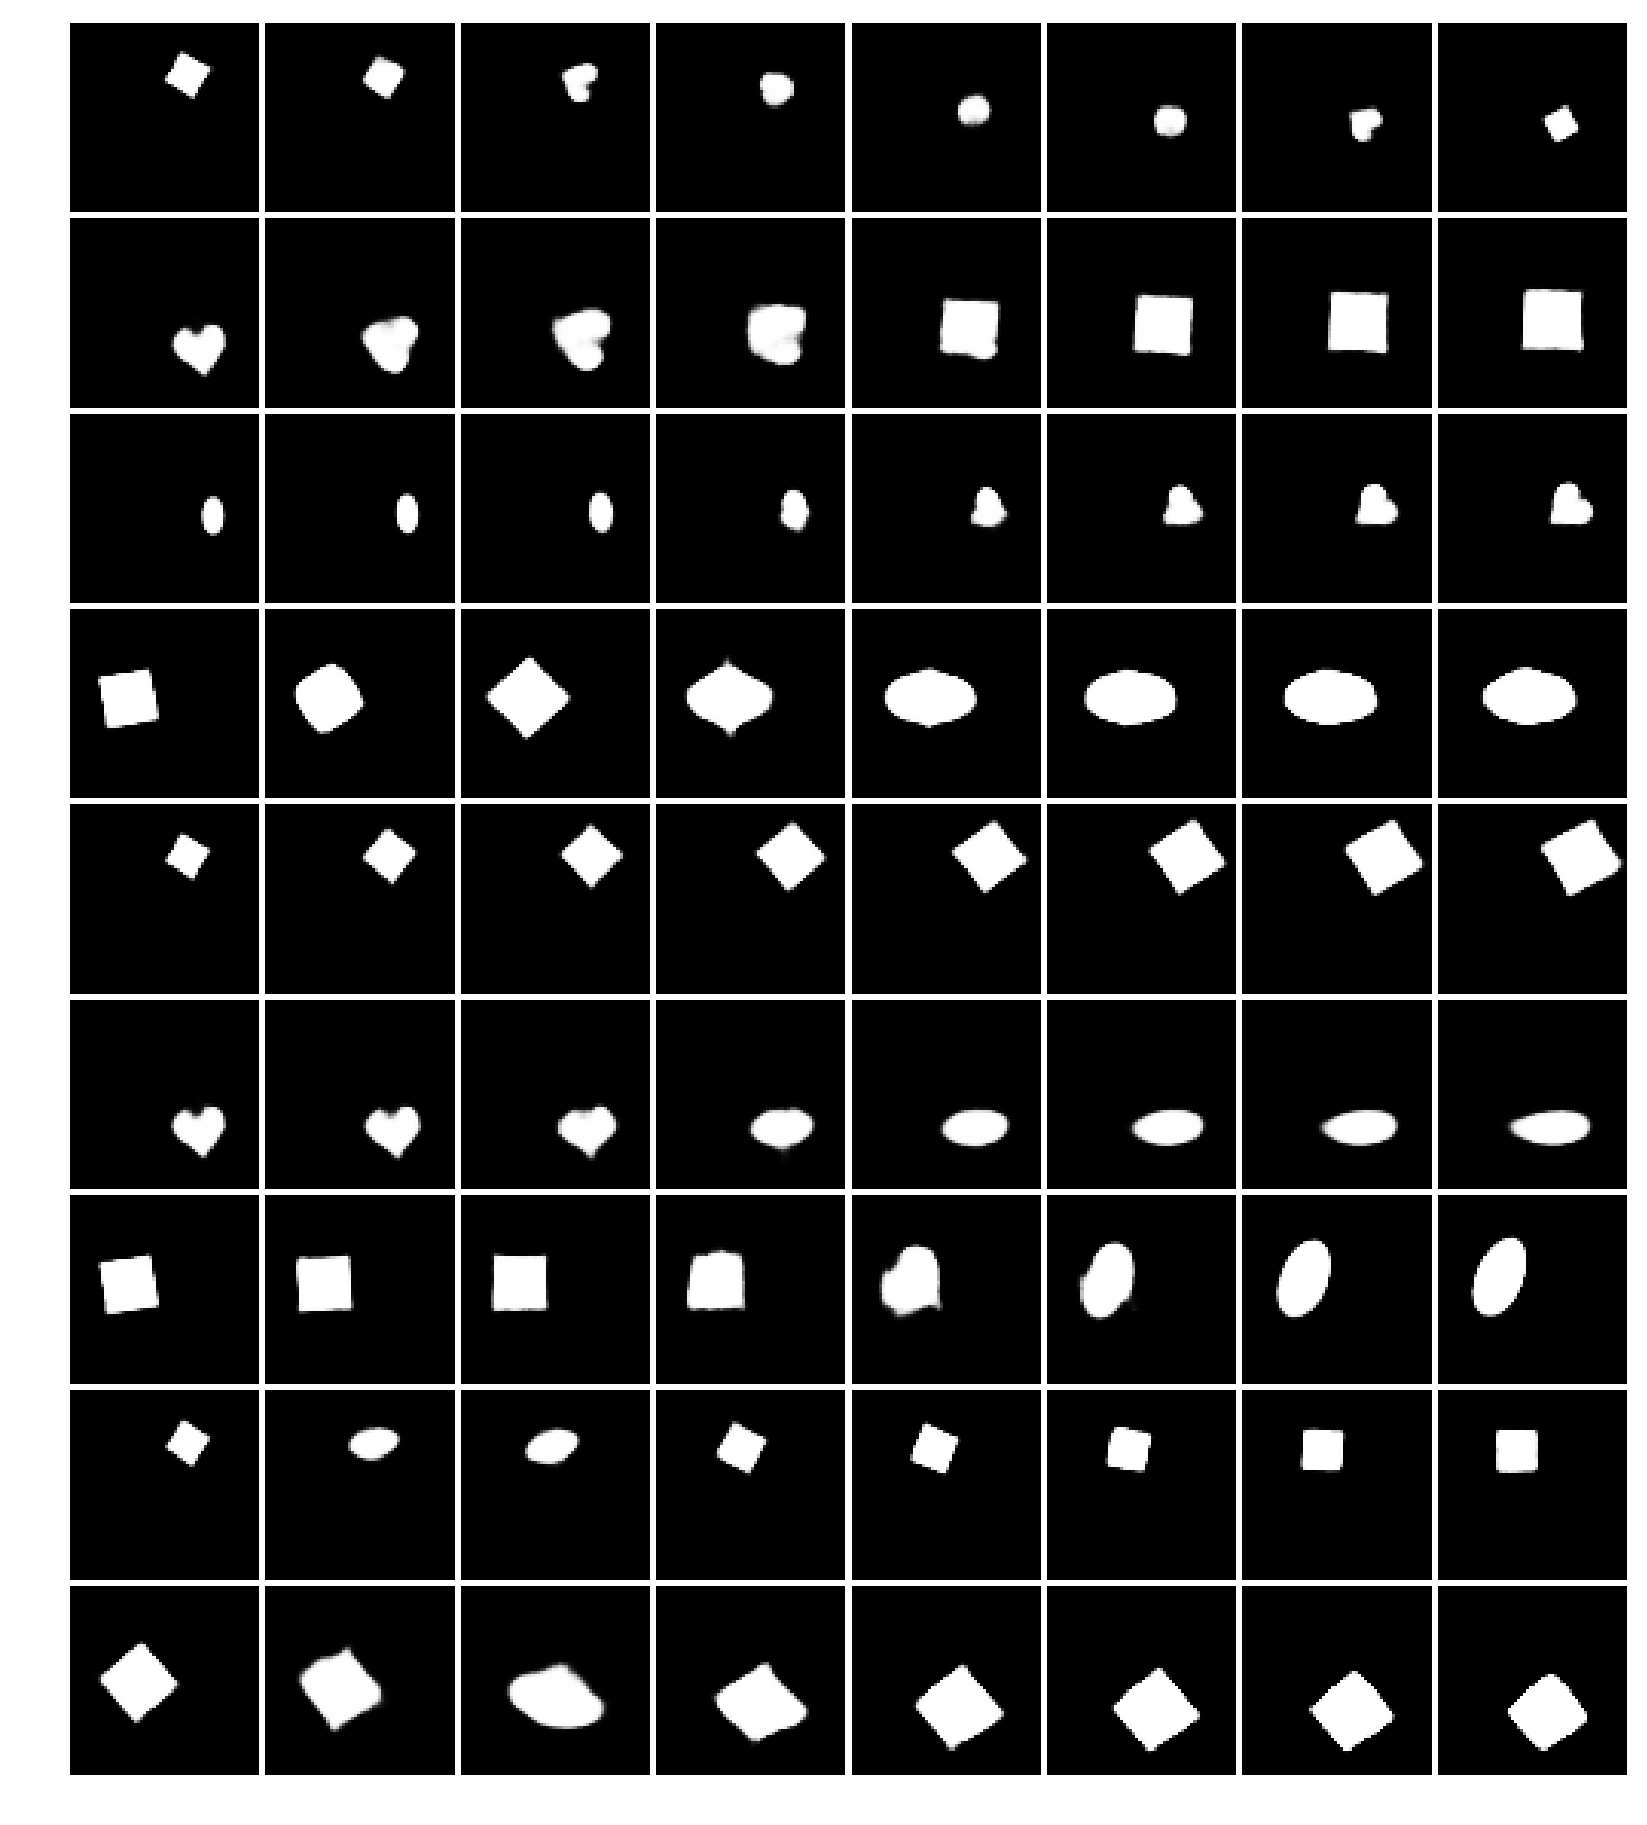

In [134]:
# 9 epochs
traversals = np.concatenate([
    plot_horizontal_traversal(images[img_idx][None,:], convvsc, 
                          model_params['latent_sz'], length=8, 
                          delta=delta, threshold=0.01,
                          plot_all=False, 
                          plot_list=[dim],
                          n_indices=19)
    for img_idx, delta, dim in [
        (2, 0.6, 81),
        (3, 0.5, 9),
        (4, 0.25, 9),
        (5, 0.7, 9),
        (2, 0.6, 93),
        (3, 0.1, 50),
        (5, 0.3, 81),
        (2, 0.5, 96),
        (-3, 0.8, 92)
    ]
])

plt.figure(figsize=(14,24))
plt.axis('off')
plt.imshow(traversals)
plt.show()